In [1]:
%pip install geopandas fiona folium shapely pyproj rtree
%pip install scikit-learn matplotlib numpy optuna pymoo
%pip install torch torchvision torchaudio
%pip install optuna pymoo pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
import torch, sys
print("Python:", sys.executable)
print("Torch:", torch.__version__)
print("CUDA in wheel:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Python: C:\Users\a\anaconda3\python.exe
Torch: 2.5.1+cu121
CUDA in wheel: 12.1
CUDA available: True
Device: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
import geopandas as gpd
import fiona
import pandas as pd
import os
from IPython.display import display

# ---------------------
# Config / Test Mode
# ---------------------
TEST_MODE = False           # True = sample only first layer + first N rows
MAX_ROWS_TEST = 1000

years = range(2015, 2019)  # 2015–2018
gdb_template = r"C:\Users\a\AISVesselTracks{year}\GreatLakes.gdb"

keep_cols = [
    "MMSI","TrackStartTime","TrackEndTime","VesselType",
    "Length","Width","Draft","DurationMinutes","VesselGroup",
    "Shape_Length","geometry"
]

gdfs = []
base_crs = None

for year in years:
    gdb_path = gdb_template.format(year=year)
    if not os.path.exists(gdb_path):
        print(f"[{year}] Path does not exist: {gdb_path}")
        continue

    layers = fiona.listlayers(gdb_path)
    non_data = {'name', 'geometry_type'}
    data_layers = [ly for ly in layers if ly not in non_data]

    if not data_layers:
        print(f"[{year}] No data layers found.")
        continue

    if TEST_MODE:
        # --- TEST MODE: first layer + row cap ---
        layer_names = [data_layers[0]]
        print(f"[{year}] TEST_MODE: reading FIRST layer only: {layer_names[0]} (max {MAX_ROWS_TEST} rows)")
    else:
        # --- FULL RUN: all layers ---
        layer_names = data_layers
        print(f"[{year}] FULL RUN: reading ALL {len(layer_names)} data layers")

    for layer_name in layer_names:
        try:
            if TEST_MODE:
                gdf_layer = gpd.read_file(gdb_path, layer=layer_name, rows=slice(0, MAX_ROWS_TEST))
            else:
                gdf_layer = gpd.read_file(gdb_path, layer=layer_name)

            if gdf_layer.empty:
                print(f"[{year}] '{layer_name}': empty, skipping.")
                continue

            # Keep only columns present
            cols_to_keep = [c for c in keep_cols if c in gdf_layer.columns]
            gdf_layer = gdf_layer[cols_to_keep].copy()

            # Track source layer & CRS
            gdf_layer["SourceLayer"] = layer_name
            if base_crs is None and getattr(gdf_layer, "crs", None) is not None:
                base_crs = gdf_layer.crs

            gdfs.append(gdf_layer)
            print(f"[{year}] Loaded {len(gdf_layer):,} rows from '{layer_name}'.")
        except Exception as e:
            print(f"[{year}] Error reading layer '{layer_name}': {e}")

# -----------------------------
# Concatenate into one GeoDF
# -----------------------------
if gdfs:
    # Align CRS and concat (preserve geometry)
    if base_crs is not None:
        gdfs = [gdf.to_crs(base_crs) if getattr(gdf, "crs", None) and gdf.crs != base_crs else gdf for gdf in gdfs]

    g_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=base_crs)
    print(f"\nCreated g_all with {len(g_all):,} rows from {len(gdfs)} layer(s).")
    display(g_all.head())
else:
    print("\nNo valid layers were read across the specified years. g_all was not created.")
    g_all = gpd.GeoDataFrame()


[2015] FULL RUN: reading ALL 12 data layers
[2015] Loaded 5,600 rows from 'Tracks_2015_01'.
[2015] Loaded 2,917 rows from 'Tracks_2015_02'.
[2015] Loaded 2,412 rows from 'Tracks_2015_03'.
[2015] Loaded 7,806 rows from 'Tracks_2015_04'.
[2015] Loaded 16,980 rows from 'Tracks_2015_05'.
[2015] Loaded 29,888 rows from 'Tracks_2015_06'.
[2015] Loaded 25,438 rows from 'Tracks_2015_07'.
[2015] Loaded 17,824 rows from 'Tracks_2015_08'.
[2015] Loaded 12,810 rows from 'Tracks_2015_09'.
[2015] Loaded 12,497 rows from 'Tracks_2015_10'.
[2015] Loaded 32,878 rows from 'Tracks_2015_11'.
[2015] Loaded 29,004 rows from 'Tracks_2015_12'.
[2016] FULL RUN: reading ALL 12 data layers
[2016] Loaded 2,075 rows from 'Tracks_2016_01'.
[2016] Loaded 1,036 rows from 'Tracks_2016_02'.
[2016] Loaded 1,273 rows from 'Tracks_2016_03'.
[2016] Loaded 3,195 rows from 'Tracks_2016_04'.
[2016] Loaded 14,076 rows from 'Tracks_2016_05'.
[2016] Loaded 17,704 rows from 'Tracks_2016_06'.
[2016] Loaded 23,767 rows from 'Tracks

,MMSI,TrackStartTime,TrackEndTime,VesselType,Length,Width,Draft,DurationMinutes,VesselGroup,Shape_Length,geometry,SourceLayer
0,235707000,2015-01-23 08:00:06+00:00,2015-01-23 08:03:27+00:00,70.0,294.0,32.0,9.9,3,Cargo,0.010496,"MULTILINESTRING ((-73.21755 45.90623, -73.2256...",Tracks_2015_01
1,235707000,2015-01-23 08:10:46+00:00,2015-01-23 08:15:05+00:00,70.0,294.0,32.0,9.9,4,Cargo,0.013937,"MULTILINESTRING ((-73.24335 45.8852, -73.24597...",Tracks_2015_01
2,235707000,2015-01-23 08:37:26+00:00,2015-01-23 08:43:45+00:00,70.0,294.0,32.0,9.9,6,Cargo,0.021022,"MULTILINESTRING ((-73.30227 45.82358, -73.3083...",Tracks_2015_01
3,235707000,2015-01-23 08:57:18+00:00,2015-01-24 15:26:31+00:00,70.0,294.0,32.0,9.9,1829,Cargo,0.252873,"MULTILINESTRING ((-73.35452 45.7834, -73.36007...",Tracks_2015_01
4,235707000,2015-01-24 16:14:34+00:00,2015-01-25 17:39:52+00:00,70.0,294.0,32.0,9.9,1525,Cargo,0.332969,"MULTILINESTRING ((-73.50448 45.59016, -73.5042...",Tracks_2015_01


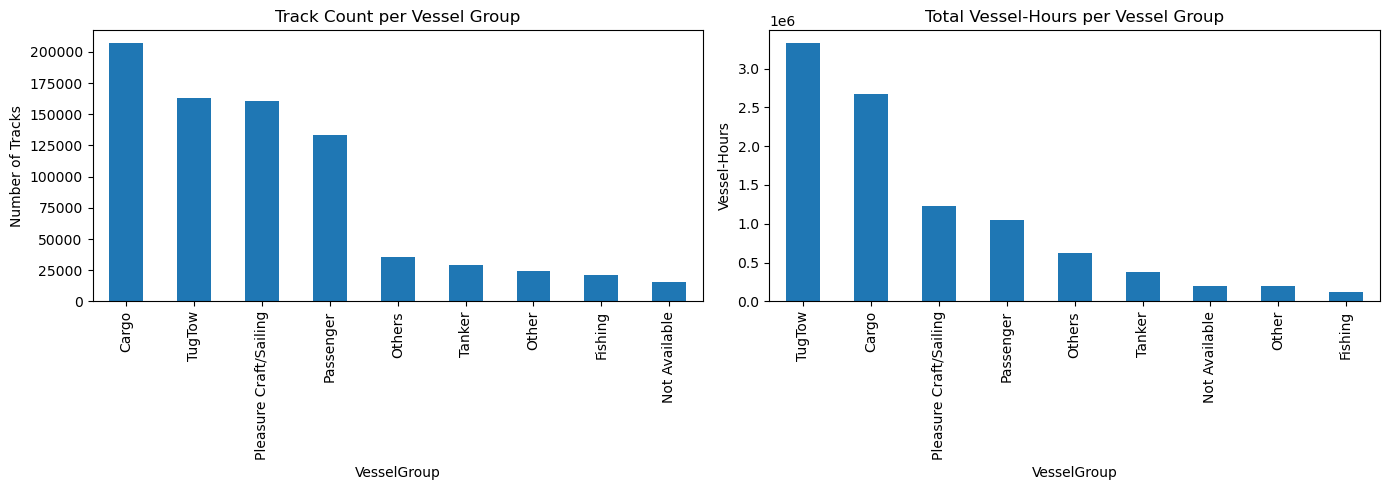

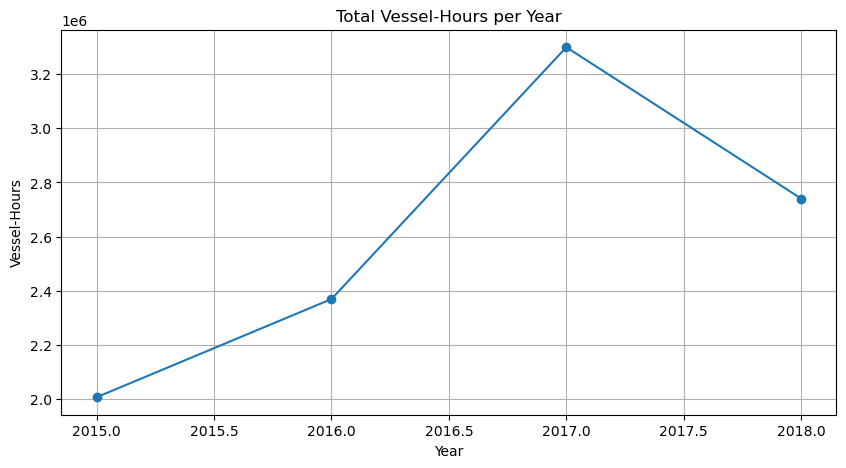

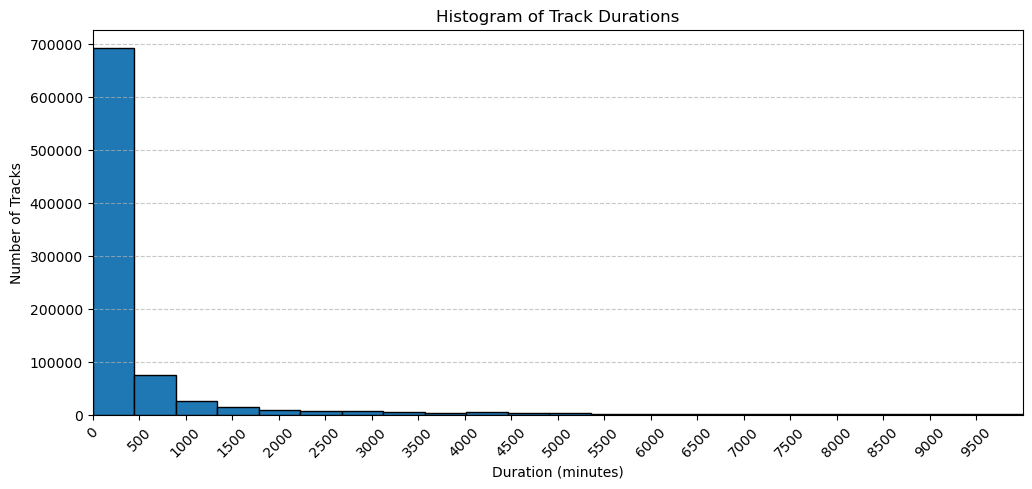

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart: Vessel type distribution
g_all["VesselHours"] = g_all["DurationMinutes"] / 60.0

counts = g_all["VesselGroup"].value_counts()
hours = g_all.groupby("VesselGroup")["VesselHours"].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
counts.plot(kind="bar", ax=axes[0], title="Track Count per Vessel Group")
axes[0].set_ylabel("Number of Tracks")

hours.plot(kind="bar", ax=axes[1], title="Total Vessel-Hours per Vessel Group")
axes[1].set_ylabel("Vessel-Hours")
plt.tight_layout()
plt.show()

# Timeline: vessel-hours per year
g_all["Year"] = g_all["TrackStartTime"].dt.year
yearly_hours = g_all.groupby("Year")["VesselHours"].sum()
yearly_hours.plot(marker="o", figsize=(10, 5), title="Total Vessel-Hours per Year")
plt.xlabel("Year"); plt.ylabel("Vessel-Hours"); plt.grid(True); plt.show()

# Histogram: track durations (in minutes)
plt.figure(figsize=(12, 5))
plt.hist(
    g_all["DurationMinutes"],
    bins=100,
    edgecolor="k"
)

plt.title("Histogram of Track Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Tracks")

# Limit x-axis
plt.xlim(0, 10000)

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-ticks every 1000 minutes
xticks = np.arange(0, 10000, 500)
plt.xticks(xticks, rotation=45)

plt.show()

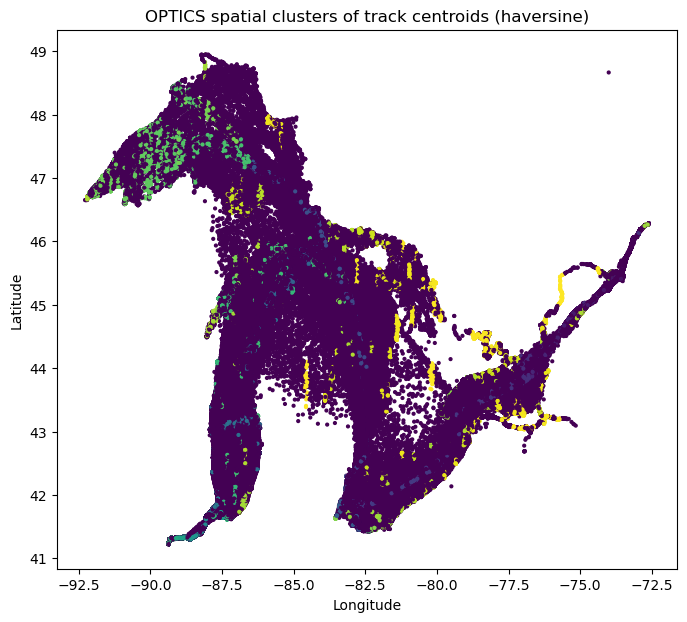


Top clusters by count:
    label   count
0     -1  640281
1     82     756
2    303     646
3    606     347
4    817     342
5   1014     330
6   2007     318
7    629     308
8    695     301
9    250     290

Cluster × VesselGroup:
 VesselGroup      Cargo  Fishing  Not Available  Other  Others  Passenger  \
OPTICS_spatial                                                             
-1.0            170812    17661          12734  20281   21834     106152   
 0.0                24        0              0      0       0          2   
 1.0                27        0              2      1       0          0   
 2.0                31        0              0      1       0          1   
 3.0                26        0              0      0       0          2   
 4.0                41        0              1      1       0          0   
 5.0                76        0              0      0       0          4   
 6.0                42        0              0      0       0          2   
 7.

In [5]:
# =========================
# Spatial clustering with OPTICS (haversine)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

# --- Params (tune these) ---
WGS84 = "EPSG:4326"
GL_ALBERS = "EPSG:3175"    # Great Lakes Albers (meters) – good for centroiding
EARTH_KM = 6371.0088

# OPTICS controls:
MIN_SAMPLES = 30           # similar role to DBSCAN's min_samples
MAX_EPS_KM  = 10.0         # upper search radius; not all clusters must use this
XI          = 0.05         # cluster extraction sensitivity (smaller -> more clusters)
CLUSTER_METHOD = "xi"      # "xi" is usually better than "dbscan" for OPTICS

# Optional: downsample for speed while you tune (set to None to use all)
DOWNSAMPLE_N = None  # e.g., 100_000

# --- 1) Clean geometries ---
g_ok = g_all[g_all.geometry.notna() & (~g_all.geometry.is_empty)].copy()
if len(g_ok) == 0:
    raise ValueError("No valid geometries in g_all.")

# Optional downsample (stratify-ish by VesselGroup if present)
if DOWNSAMPLE_N is not None and len(g_ok) > DOWNSAMPLE_N:
    if "VesselGroup" in g_ok.columns:
        g_ok = (
            g_ok.groupby("VesselGroup", group_keys=False)
                .apply(lambda df: df.sample(min(len(df), max(1, DOWNSAMPLE_N // max(1, g_ok['VesselGroup'].nunique()))),
                                            random_state=42))
        )
    else:
        g_ok = g_ok.sample(DOWNSAMPLE_N, random_state=42)

# --- 2) Centroids in projected CRS (meters) to avoid geographic centroid issues ---
g_proj = g_ok.to_crs(GL_ALBERS)
cent_proj = g_proj.geometry.centroid

# --- 3) Convert centroids back to WGS84 (lon/lat), then to radians for haversine ---
cent_ll = cent_proj.to_crs(WGS84)
coords_deg = np.column_stack([cent_ll.x.values, cent_ll.y.values]).astype(np.float64)

# Drop rows with non-finite coords; keep index mapping to assign labels back
valid_mask = np.isfinite(coords_deg).all(axis=1)
coords_deg = coords_deg[valid_mask]
idx_keep = g_ok.index.to_numpy()[valid_mask]

if coords_deg.shape[0] == 0:
    raise ValueError("No valid centroids to cluster after cleaning.")

coords_rad = np.radians(coords_deg)           # haversine expects radians
max_eps_rad = MAX_EPS_KM / EARTH_KM           # convert km -> radians

# --- 4) OPTICS clustering (memory-friendlier than DBSCAN) ---
opt = OPTICS(
    metric="haversine",
    min_samples=MIN_SAMPLES,
    max_eps=max_eps_rad,     # upper bound; OPTICS builds reachability over a range
    cluster_method=CLUSTER_METHOD,
    xi=XI
)
labels = opt.fit_predict(coords_rad)  # -1 = noise

# --- 5) Attach labels back to g_all (others = NaN) ---
g_all["OPTICS_spatial"] = np.nan
g_all.loc[idx_keep, "OPTICS_spatial"] = labels

# --- 6) Quick visuals & summaries ---
plt.figure(figsize=(8,7))
plt.scatter(coords_deg[:,0], coords_deg[:,1], c=labels, s=4)
plt.title("OPTICS spatial clusters of track centroids (haversine)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

# Cluster sizes
summary = (
    pd.DataFrame({"label": labels})
      .value_counts("label")
      .rename("count").reset_index()
      .sort_values("count", ascending=False)
)
print("\nTop clusters by count:\n", summary.head(10))

# Optional: cluster × vessel group crosstab
if "VesselGroup" in g_all.columns:
    ctab = pd.crosstab(g_all["OPTICS_spatial"], g_all["VesselGroup"])
    print("\nCluster × VesselGroup:\n", ctab.head(10))


[prep] centroids ready: 794,050 points

[tune] top 10 settings by heuristic ranking:
 max_eps_km  min_samples   xi      n  noise_pct  n_clusters  largest_cluster
       15.0           10 0.03 150000       47.6        4471               64
       20.0           10 0.03 150000       47.6        4471               64
       25.0           10 0.03 150000       47.6        4471               64
       30.0           10 0.03 150000       47.6        4471               64
       15.0           10 0.04 150000       50.2        4266               64
       20.0           10 0.04 150000       50.2        4266               64
       25.0           10 0.04 150000       50.2        4266               64
       30.0           10 0.04 150000       50.2        4266               64
       15.0           10 0.05 150000       53.2        4021               64
       20.0           10 0.05 150000       53.2        4021               64

[chosen] max_eps_km=15.0, min_samples=10, xi=0.03

[final] n=794,05

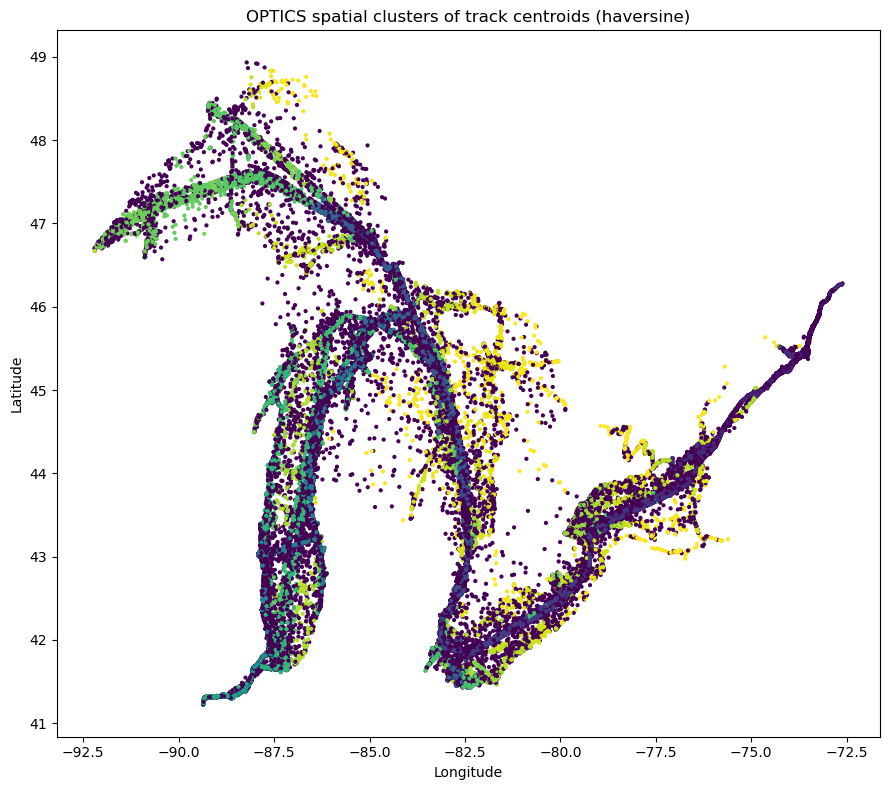


Cluster summary (head):
          count    lon_med    lat_med
label                               
-1      405632 -83.158532  43.747432
 888        73 -73.545717  45.509269
 2200       66 -76.098807  44.248507
 20602      65 -77.803306  44.298500
 14232      64 -87.701906  43.752230
 20020      64 -80.791104  41.913578
 18426      64 -79.703665  43.393188
 7639       63 -84.675681  45.857102
 14261      62 -87.648309  44.095922
 17745      61 -83.109311  41.746909


In [6]:
# =========================
# OPTICS spatial clustering for g_all (Great Lakes)
# =========================
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.utils import check_random_state

# ------------------ Config ------------------
WGS84 = "EPSG:4326"
GL_ALBERS = "EPSG:3175"          # Great Lakes Albers (meters) — safe for centroiding
EARTH_KM = 6371.0088

# Main OPTICS params (used after tuning step; adjust if you skip tuning)
MAX_EPS_KM  = 25.0               # neighborhood search radius (km)
MIN_SAMPLES = 20                 # minimum points in neighborhood
XI          = 0.04               # extraction sensitivity; smaller -> more clusters

# OPTIONAL: quick tuning on a sample first (speeds up param selection)
DO_TUNE          = True
TUNE_SAMPLE_N    = 150_000       # how many centroids to sample for tuning; set None to use all
TUNE_MAX_EPS_KMS = [15.0, 20.0, 25.0, 30.0]
TUNE_MIN_SAMPLES = [30, 20, 10]
TUNE_XIS         = [0.05, 0.04, 0.03]

# OPTIONAL: downsample for final plotting so the scatter is responsive
PLOT_SAMPLE_N = 50_000

# Seed for reproducibility
RNG = check_random_state(42)

# ------------------ Helpers ------------------
def compute_centroids_ll(gdf: gpd.GeoDataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Return (coords_deg Nx2, idx_keep) for valid centroids (lon, lat)."""
    g_ok = gdf[gdf.geometry.notna() & (~gdf.geometry.is_empty)].copy()
    if len(g_ok) == 0:
        raise ValueError("No valid geometries in g_all.")
    # centroid in meters -> back to lon/lat
    cent_proj = g_ok.to_crs(GL_ALBERS).geometry.centroid
    cent_ll = cent_proj.to_crs(WGS84)
    coords_deg = np.column_stack([cent_ll.x.values, cent_ll.y.values]).astype(np.float64)
    valid = np.isfinite(coords_deg).all(axis=1)
    return coords_deg[valid], g_ok.index.to_numpy()[valid]

def run_optics(coords_deg: np.ndarray, max_eps_km: float, min_samples: int, xi: float) -> np.ndarray:
    coords_rad = np.radians(coords_deg)
    opt = OPTICS(
        metric="haversine",
        max_eps=max_eps_km / EARTH_KM,
        min_samples=min_samples,
        cluster_method="xi",
        xi=xi
    )
    return opt.fit_predict(coords_rad)  # -1 = noise

def summarize_labels(labels: np.ndarray) -> pd.DataFrame:
    vc = pd.Series(labels).value_counts().rename_axis("label").rename("count").reset_index()
    vc = vc.sort_values("count", ascending=False)
    return vc

def quality_metrics(labels: np.ndarray) -> dict:
    n = len(labels)
    if n == 0:
        return {"n": 0, "noise_pct": 100.0, "n_clusters": 0, "largest_cluster": 0}
    noise = np.sum(labels == -1)
    counts = pd.Series(labels).value_counts()
    # largest non-noise cluster size
    largest = counts[counts.index != -1].max() if any(counts.index != -1) else 0
    return {
        "n": n,
        "noise_pct": round(noise / n * 100.0, 1),
        "n_clusters": (len(set(labels)) - (1 if -1 in labels else 0)),
        "largest_cluster": int(largest)
    }

def tune_params(coords_deg: np.ndarray) -> tuple[float, int, float, pd.DataFrame]:
    grid_results = []
    # sample for tuning if needed
    if TUNE_SAMPLE_N is not None and len(coords_deg) > TUNE_SAMPLE_N:
        idx = RNG.choice(len(coords_deg), size=TUNE_SAMPLE_N, replace=False)
        coords_tune = coords_deg[idx]
    else:
        coords_tune = coords_deg

    for me in TUNE_MAX_EPS_KMS:
        for ms in TUNE_MIN_SAMPLES:
            for xi in TUNE_XIS:
                lab = run_optics(coords_tune, me, ms, xi)
                qm = quality_metrics(lab)
                grid_results.append({
                    "max_eps_km": me, "min_samples": ms, "xi": xi,
                    **qm
                })

    df = pd.DataFrame(grid_results)
    # heuristic ranking: aim for low noise, reasonable number of clusters, large biggest cluster
    df = df.sort_values(["noise_pct", "n_clusters", "largest_cluster"], ascending=[True, False, False])
    best = df.iloc[0]
    return float(best["max_eps_km"]), int(best["min_samples"]), float(best["xi"]), df

# ------------------ Run ------------------
assert 'g_all' in globals(), "Please define g_all before running this cell."

# 1) Coordinates and index mapping
coords_deg, idx_keep = compute_centroids_ll(g_all)
print(f"[prep] centroids ready: {len(coords_deg):,} points")

# 2) Optional tuning on a sample
if DO_TUNE:
    best_me, best_ms, best_xi, tune_table = tune_params(coords_deg)
    print("\n[tune] top 10 settings by heuristic ranking:")
    print(tune_table.head(10).to_string(index=False))
    MAX_EPS_KM, MIN_SAMPLES, XI = best_me, best_ms, best_xi
    print(f"\n[chosen] max_eps_km={MAX_EPS_KM}, min_samples={MIN_SAMPLES}, xi={XI}")

# 3) Final OPTICS on full set with chosen params
labels_full = run_optics(coords_deg, MAX_EPS_KM, MIN_SAMPLES, XI)
qm = quality_metrics(labels_full)
print(f"\n[final] n={qm['n']:,}  clusters={qm['n_clusters']}  noise={qm['noise_pct']}%  "
      f"largest_non_noise={qm['largest_cluster']:,}")

# 4) Attach labels back to g_all (others = NaN)
g_all["OPTICS_spatial"] = np.nan
g_all.loc[idx_keep, "OPTICS_spatial"] = labels_full

# 5) Summaries
top_counts = summarize_labels(labels_full)
print("\nTop clusters by count:\n", top_counts.head(10).to_string(index=False))

if "VesselGroup" in g_all.columns:
    # To keep crosstab readable, restrict to top 10 cluster labels by count
    top_labels = top_counts.loc[top_counts["label"] != -1].head(10)["label"].tolist()
    mask = g_all["OPTICS_spatial"].isin(top_labels + [-1]).fillna(False)
    ctab = pd.crosstab(g_all.loc[mask, "OPTICS_spatial"], g_all.loc[mask, "VesselGroup"])
    print("\nCluster × VesselGroup (top labels + noise):\n", ctab.to_string())

# 6) Quick plot (sample for responsiveness)
if PLOT_SAMPLE_N is not None and len(coords_deg) > PLOT_SAMPLE_N:
    sidx = RNG.choice(len(coords_deg), size=PLOT_SAMPLE_N, replace=False)
    Pcoords = coords_deg[sidx]
    Plabels = labels_full[sidx]
else:
    Pcoords, Plabels = coords_deg, labels_full

plt.figure(figsize=(9,8))
plt.scatter(Pcoords[:,0], Pcoords[:,1], c=Plabels, s=4)
plt.title("OPTICS spatial clusters of track centroids (haversine)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# 7) Optional: store a compact cluster summary DataFrame for reporting
#    (cluster id, count, median lon/lat)
df_summary = (
    pd.DataFrame({
        "label": labels_full,
        "lon": coords_deg[:,0],
        "lat": coords_deg[:,1]
    })
    .groupby("label")
    .agg(count=("label","size"), lon_med=("lon","median"), lat_med=("lat","median"))
    .sort_values("count", ascending=False)
)
print("\nCluster summary (head):\n", df_summary.head(10).to_string())


[prep] centroids ready: 794,050 points
[kmeans] n=794,050  K=3,970  batch_size=8192
[dbscan] clusters=35  noise=29.5%  largest_cluster=127,360

Top clusters by count:
  label  count
    -1 233987
     0 127360
     3  92173
     1  59248
     5  37977
     2  35377
     7  30398
     8  20148
    12  16610
    13  15340


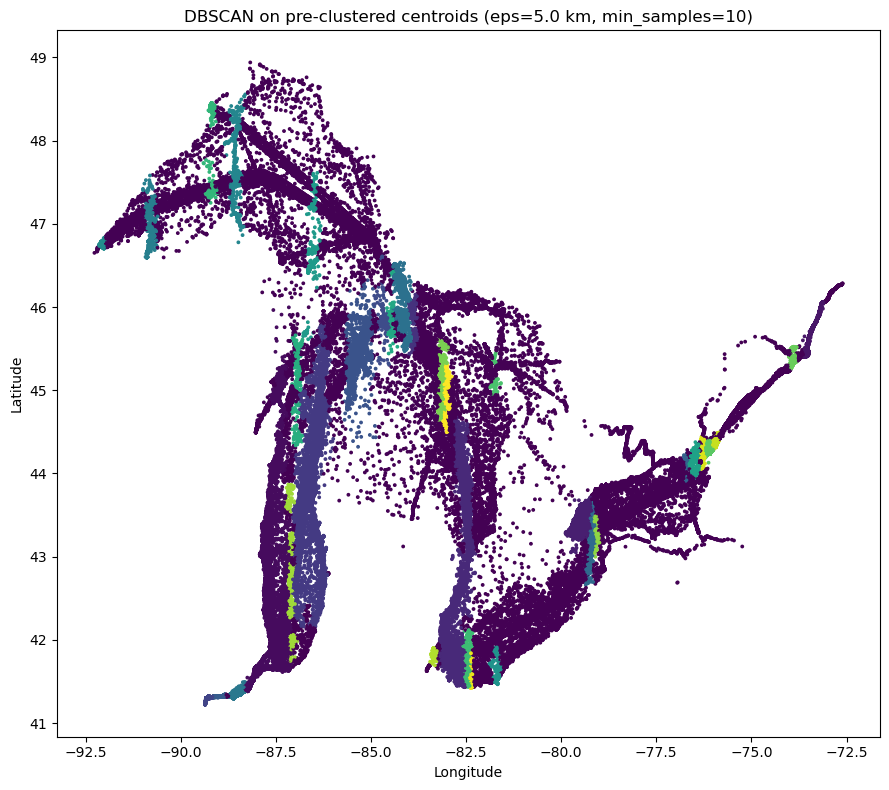

In [7]:
# =========================================
# DBSCAN on pre-clustered centroids (Windows-safe)
# =========================================
import os
# --- Set env BEFORE importing sklearn to avoid loky/MKL quirks on Windows ---
os.environ.setdefault("PYTHONUTF8", "1")         # make subprocess decoding UTF-8
os.environ.setdefault("LOKY_MAX_CPU_COUNT", "8") # skip fragile physical-core detection
os.environ.setdefault("OMP_NUM_THREADS", "8")    # tame MKL/OpenMP threads
os.environ.setdefault("MKL_NUM_THREADS", "8")

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, DBSCAN

# ------------------ Config ------------------
WGS84 = "EPSG:4326"
GL_ALBERS = "EPSG:3175"   # Great Lakes Albers (meters)
EARTH_KM = 6371.0088

# DBSCAN (haversine) — tune these if you want coarser/finer clusters
EPS_KM      = 5.0
MIN_SAMPLES = 10
EPS_RAD     = EPS_KM / EARTH_KM

# MiniBatchKMeans pre-cluster (run k-means in meters!)
BATCH_SIZE = 8192     # >= 6144 to avoid MKL leak warning on Windows
RNG_SEED   = 42

# Choose K based on size; cap to keep runtime/memory sane
def choose_K(n):
    # ~0.5% of points, bounded between 1k and 5k
    return int(np.clip(round(n * 0.005), 1000, 5000))

# Plotting (downsample for responsiveness)
PLOT_SAMPLE_N = 120_000

# ------------------ 1) Valid centroids (in meters, then lon/lat) ------------------
assert 'g_all' in globals(), "Please define g_all before running this cell."
if "geometry" not in g_all.columns:
    raise ValueError("g_all must have a 'geometry' column.")

g_ok = g_all[g_all.geometry.notna() & (~g_all.geometry.is_empty)].copy()
if g_ok.empty:
    raise ValueError("No valid geometries in g_all.")

# Centroids in Albers (meters) -> better for k-means geometry
cent_proj = g_ok.to_crs(GL_ALBERS).geometry.centroid
coords_m  = np.column_stack([cent_proj.x.values, cent_proj.y.values]).astype(np.float64)

# Also prepare WGS84 lon/lat for plotting & haversine DBSCAN
cent_ll   = gpd.GeoSeries(cent_proj, crs=GL_ALBERS).to_crs(WGS84)
coords_deg = np.column_stack([cent_ll.x.values, cent_ll.y.values]).astype(np.float64)

valid = np.isfinite(coords_m).all(axis=1) & np.isfinite(coords_deg).all(axis=1)
coords_m   = coords_m[valid]
coords_deg = coords_deg[valid]
idx_keep   = g_ok.index.to_numpy()[valid]

n_pts = coords_m.shape[0]
print(f"[prep] centroids ready: {n_pts:,} points")
if n_pts == 0:
    raise ValueError("No finite centroids after cleaning.")

# ------------------ 2) Pre-cluster with MiniBatchKMeans (meters) ------------------
K = choose_K(n_pts)
print(f"[kmeans] n={n_pts:,}  K={K:,}  batch_size={BATCH_SIZE}")

# NOTE: if your sklearn complains about n_init='auto', set n_init=10
kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=BATCH_SIZE,
    random_state=RNG_SEED,
    n_init=10
)
labels_k = kmeans.fit_predict(coords_m.astype(np.float32))
centroids_m = kmeans.cluster_centers_.astype(np.float64)

# Convert k-means centers back to lon/lat for haversine
centroids_ll = gpd.GeoSeries(
    gpd.points_from_xy(centroids_m[:,0], centroids_m[:,1]),
    crs=GL_ALBERS
).to_crs(WGS84)
centroids_deg = np.column_stack([centroids_ll.x.values, centroids_ll.y.values]).astype(np.float64)

# ------------------ 3) DBSCAN on the pre-cluster centroids (haversine) ------------------
cent_rad = np.radians(centroids_deg)
db = DBSCAN(eps=EPS_RAD, min_samples=MIN_SAMPLES, metric="haversine")
lab_cent = db.fit_predict(cent_rad)

# ------------------ 4) Propagate labels back to original points ------------------
lab_points = lab_cent[labels_k]

g_all["DBSCAN_spatial"] = np.nan
g_all.loc[idx_keep, "DBSCAN_spatial"] = lab_points

# ------------------ 5) Quick summary ------------------
lab_vals, lab_counts = np.unique(lab_points, return_counts=True)
summary = pd.DataFrame({"label": lab_vals, "count": lab_counts}).sort_values("count", ascending=False)

n_noise = int(summary.loc[summary["label"] == -1, "count"].sum()) if (-1 in summary["label"].values) else 0
noise_pct = 100.0 * n_noise / len(lab_points)
n_clusters = int((summary["label"] != -1).sum())

largest = int(summary.query("label != -1")["count"].max()) if n_clusters > 0 else 0

print(f"[dbscan] clusters={n_clusters:,}  noise={noise_pct:.1f}%  largest_cluster={largest:,}")
print("\nTop clusters by count:\n", summary.head(10).to_string(index=False))

# ------------------ 6) Plot (downsample for speed) ------------------
if (PLOT_SAMPLE_N is not None) and (len(coords_deg) > PLOT_SAMPLE_N):
    rng = np.random.default_rng(42)
    sidx = rng.choice(len(coords_deg), size=PLOT_SAMPLE_N, replace=False)
    Pcoords = coords_deg[sidx]
    Plabels = lab_points[sidx]
else:
    Pcoords = coords_deg
    Plabels = lab_points

plt.figure(figsize=(9, 8))
plt.scatter(Pcoords[:,0], Pcoords[:,1], c=Plabels, s=3)
plt.title(f"DBSCAN on pre-clustered centroids (eps={EPS_KM} km, min_samples={MIN_SAMPLES})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout(); plt.show()


In [8]:
# Compute centroids in projected CRS (meters) to avoid warning
cent_proj = g_all.to_crs("EPSG:3175").geometry.centroid

# Convert back to WGS84 (lon/lat)
cent_ll = gpd.GeoSeries(cent_proj, crs="EPSG:3175").to_crs("EPSG:4326")

df_summary = (
    pd.DataFrame({
        "label": g_all["DBSCAN_spatial"],
        "lon": cent_ll.x.values,
        "lat": cent_ll.y.values
    })
    .dropna(subset=["label"])
    .groupby("label")
    .agg(
        count=("label", "size"),
        lon_med=("lon", "median"),
        lat_med=("lat", "median")
    )
    .sort_values("count", ascending=False)
)

print(df_summary.head(10).to_string(index=True))


        count    lon_med    lat_med
label                              
-1.0   233987 -81.972205  44.780062
 0.0   127360 -87.636922  41.878067
 3.0    92173 -82.717178  42.297260
 1.0    59248 -73.500828  45.603906
 5.0    37977 -86.448399  43.565223
 2.0    35377 -79.391248  43.619987
 7.0    30398 -84.669368  45.843826
 8.0    20148 -85.251790  45.394621
 12.0   16610 -84.211296  46.284626
 13.0   15340 -88.537643  41.331921


In [9]:
# =========================
# A) Setup, config, utils
# =========================
import os, gc, sys, math, time, random, warnings, glob, csv
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import linemerge
from shapely.geometry import LineString
from datetime import timedelta
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import joblib

import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, Dataset, DataLoader

# Progress bars in plain text mode (no widgets)
try:
    from tqdm import tqdm as _tqdm
    def tqdm(iterable, **kw): return _tqdm(iterable, **kw)
except Exception:
    def tqdm(iterable, **kw): return iterable  # no-op

# ---------------- Config ----------------
WGS84 = "EPSG:4326"
DEFAULT_DT_MIN = 2

WIN_T = 60
WIN_STRIDE = 10
STOP_SPEED_MPS = 0.2

BATCH_SIZE   = 64
AE_EPOCHS    = 10
PRED_EPOCHS  = 10
LR           = 1e-3
WEIGHT_DECAY = 1e-4

FUSE_ALPHA    = 0.5
THR_QUANTILE  = 0.995
MAX_STEPS_RESAMPLE = 2000

# Streaming/cache settings
CACHE_DIR = Path("./cache_streaming"); CACHE_DIR.mkdir(parents=True, exist_ok=True)
CHUNK_ROWS = 1000
SAMPLE_PARTS = 5
SAMPLE_ROWS_PER_PART = 40000
SHARD_MAX_WINDOWS = 20000

# Seeds
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Feature columns
INPUT_COLS = [
    "speed_mps","accel_mps2","turn_rate_dps",
    "tod_sin","tod_cos","dow_sin","dow_cos",
    "dt_seconds","Length","Width","Draft","VesselType"
]
TARGET_COLS_PRED = ["speed_mps","turn_rate_dps","accel_mps2"]

# -------------- Helpers --------------
class Timer:
    def __init__(self, label=""): self.label = label
    def __enter__(self): self.t0 = time.time(); return self
    def __exit__(self, *exc):
        print(f"[{self.label}] done in {time.time()-self.t0:0.2f}s")

def pretty_n(x): 
    return f"{x:,}"

def get_dt_minutes(vessel_type):
    # Simple, robust default. Reintroduce a map if you really need type-specific dt.
    return DEFAULT_DT_MIN

def bearing_deg(dx, dy):
    return (np.degrees(np.arctan2(dy, dx)) + 360.0) % 360.0

def unwrap_deg(angles):
    a = np.asarray(angles, dtype=float)
    return np.degrees(np.unwrap(np.radians(a)))

def circ_diff_deg(a2, a1):
    return (a2 - a1 + 180) % 360 - 180

def best_utm_crs(lat, lon):
    zone = int((lon + 180) // 6) + 1
    south = lat < 0
    epsg = 32700 + zone if south else 32600 + zone
    return f"EPSG:{epsg}"

def ensure_utc_series(s):
    """Return tz-aware UTC datetime series/index without pandas deprecation warnings."""
    if pd.api.types.is_datetime64_any_dtype(s):
        try:
            if getattr(s.dt, "tz", None) is not None:
                return s.dt.tz_convert("UTC")
            return s.dt.tz_localize("UTC")
        except AttributeError:
            if getattr(s, "tz", None) is not None:
                return s.tz_convert("UTC")
            return s.tz_localize("UTC")
    return pd.to_datetime(s, utc=True, errors="coerce")

def ensure_utc_ts(x):
    """Return a single pandas.Timestamp in UTC (tz-aware)."""
    if isinstance(x, pd.Timestamp):
        return x.tz_convert("UTC") if x.tzinfo else x.tz_localize("UTC")
    return pd.to_datetime(x, utc=True, errors="coerce")

def _sanitize_np(a, clip=10.0):
    """replace nan/inf and clip to a reasonable range"""
    a = np.nan_to_num(a, nan=0.0, posinf=clip, neginf=-clip)
    if clip is not None:
        a = np.clip(a, -clip, clip)
    return a

print("Config:",
      f"\n  WIN_T={WIN_T}, STRIDE={WIN_STRIDE}",
      f"\n  AE_EPOCHS={AE_EPOCHS}, PRED_EPOCHS={PRED_EPOCHS}",
      f"\n  BATCH={BATCH_SIZE}, LR={LR}, WD={WEIGHT_DECAY}",
      f"\n  THR_QUANTILE={THR_QUANTILE}, FUSE_ALPHA={FUSE_ALPHA}",
      f"\n  CHUNK_ROWS={CHUNK_ROWS}, SHARD_MAX_WINDOWS={SHARD_MAX_WINDOWS}")

# =========================
# B) Dataset split
# =========================
assert 'g_all' in globals(), "Please define g_all before running this cell."

with Timer("g_all sanity"):
    print("g_all shape:", g_all.shape)
    print("Columns:", list(g_all.columns))
    print("CRS:", getattr(g_all, "crs", None))
    ts_start = ensure_utc_series(g_all.get("TrackStartTime"))
    ts_end   = ensure_utc_series(g_all.get("TrackEndTime"))
    print("Time range:", ts_start.min(), "→", ts_end.max())

assert "MMSI" in g_all.columns, "Need MMSI column for split."
mmsi_all = g_all["MMSI"].astype(str)
mmsi_train, mmsi_val = train_test_split(mmsi_all.unique(), test_size=0.2, random_state=SEED)
MMSI_TRAIN = set(mmsi_train)
MMSI_VAL   = set(mmsi_val)
print(f"[split] train MMSIs={len(MMSI_TRAIN):,}  val MMSIs={len(MMSI_VAL):,}")

IDX2MMSI = g_all["MMSI"].astype(str)

# =========================
# C) Processing functions
# =========================
def resample_track_row(row, line_col="geometry", start_col="TrackStartTime", dur_col="DurationMinutes"):
    geom = row[line_col]
    if geom is None or geom.is_empty:
        return None

    # Robust UTC start time
    t0 = ensure_utc_ts(row.get(start_col))
    if t0 is None or pd.isna(t0):
        return None

    # Robust duration parsing
    try:
        duration_min = float(row.get(dur_col, np.nan))
    except Exception:
        return None
    if not np.isfinite(duration_min) or duration_min <= 0:
        return None

    # Merge/flatten geometry
    merged = linemerge(geom)
    if merged.is_empty:
        return None
    if merged.geom_type == "MultiLineString":
        coords = []
        for line in merged.geoms:
            coords.extend(list(line.coords))
        merged = LineString(coords)
        if merged.is_empty or len(merged.coords) < 2:
            return None

    # Use input CRS if present; assume WGS84 otherwise
    src_crs = g_all.crs if g_all.crs else WGS84

    # Convert to WGS84 then local UTM by centroid
    gseries_ll = gpd.GeoSeries([merged], crs=src_crs).to_crs(WGS84)
    cent = gseries_ll.iloc[0].centroid
    utm = best_utm_crs(cent.y, cent.x)

    gseries_m = gseries_ll.to_crs(utm)
    line_m = gseries_m.iloc[0]
    L = float(line_m.length)
    if not np.isfinite(L) or L <= 0:
        return None

    # Sampling cadence
    dt_min = get_dt_minutes(row.get("VesselType", None))
    dt_sec = max(1, int(dt_min * 60))
    total_sec = int(duration_min * 60)

    N = max(2, total_sec // dt_sec + 1)
    N = min(N, MAX_STEPS_RESAMPLE)

    # Parametric sampling along the polyline
    dists = [(i / (N - 1)) * L for i in range(N)]
    times = [t0 + timedelta(seconds=i * dt_sec) for i in range(N)]

    pts_m = [line_m.interpolate(d) for d in dists]
    gdf_m = gpd.GeoDataFrame({"timestamp": times}, geometry=pts_m, crs=utm)
    gdf_ll = gdf_m.to_crs(WGS84)

    df = gdf_m.copy()
    df["x_m"] = gdf_m.geometry.x.values
    df["y_m"] = gdf_m.geometry.y.values
    df["lon"] = gdf_ll.geometry.x.values
    df["lat"] = gdf_ll.geometry.y.values
    df["dt_seconds"] = dt_sec

    for col in ["VesselType", "Length", "Width", "Draft", "MMSI"]:
        df[col] = row[col] if (col in row.index) else None

    df["track_length_m"] = L
    return df.drop(columns="geometry")

def add_kinematic_features(df):
    df = df.sort_values("timestamp").reset_index(drop=True)
    if "dt_seconds" not in df.columns:
        df["dt_seconds"] = int(DEFAULT_DT_MIN * 60)
    dt = np.maximum(df["dt_seconds"].astype(float).values, 1.0)

    x = df["x_m"].values; y = df["y_m"].values
    dx = np.diff(x, prepend=x[0]); dy = np.diff(y, prepend=y[0])
    dist = np.hypot(dx, dy)

    speed = dist / dt
    brg = bearing_deg(dx, dy)
    brg_unw = unwrap_deg(brg)
    dbrg = np.diff(brg_unw, prepend=brg_unw[0])
    turn_rate = dbrg / dt
    accel = np.diff(speed, prepend=speed[0]) / dt

    df["dx_m"] = dx; df["dy_m"] = dy; df["step_dist_m"] = dist
    df["speed_mps"] = speed; df["bearing_deg"] = brg
    df["turn_rate_dps"] = turn_rate; df["accel_mps2"] = accel
    df["stopped"] = (df["speed_mps"] < STOP_SPEED_MPS).astype(int)

    ts = ensure_utc_series(df["timestamp"])
    hod = ts.dt.hour + ts.dt.minute/60.0
    df["tod_sin"] = np.sin(2*np.pi*hod/24.0); df["tod_cos"] = np.cos(2*np.pi*hod/24.0)
    dow = ts.dt.weekday
    df["dow_sin"] = np.sin(2*np.pi*dow/7.0); df["dow_cos"] = np.cos(2*np.pi*dow/7.0)
    return df

def process_chunk(df_chunk, part_id):
    seqs = []; ok=0; skipped=0
    for i, row in df_chunk.iterrows():
        try:
            s = resample_track_row(row)
            if s is None or len(s) < 3:
                skipped += 1; continue
            s = add_kinematic_features(s)
            s["seq_id"] = i
            s["MMSI"] = str(row.get("MMSI", ""))
            seqs.append(s); ok += 1
        except Exception:
            skipped += 1
    if not seqs:
        return None, ok, skipped

    long_tbl = pd.concat(seqs, ignore_index=True)
    out = CACHE_DIR / f"long_part_{part_id:04d}.parquet"
    try:
        long_tbl.to_parquet(out, engine="pyarrow")
    except Exception as e:
        raise RuntimeError(f"Failed to write {out}. Is 'pyarrow' installed?") from e
    return out, ok, skipped
    
# =========================
# D) Processing loop (Pass 1)
# =========================
LONG_PARTS = []
n = len(g_all)
print(f"[pass1] resampling {n:,} rows in chunks of {CHUNK_ROWS}…")
tot_ok=tot_skipped=0

for part_id, start in enumerate(tqdm(range(0, n, CHUNK_ROWS), desc="Pass1: resample", ncols=80)):
    chunk = g_all.iloc[start:start+CHUNK_ROWS]
    path, ok, skipped = process_chunk(chunk, part_id)
    if path is not None:
        LONG_PARTS.append(str(path))
    tot_ok += ok; tot_skipped += skipped
    del chunk, path, ok, skipped
    gc.collect()

print(f"[pass1] parts={len(LONG_PARTS)}  ok={tot_ok:,}  skipped={tot_skipped:,}")


Config: 
  WIN_T=60, STRIDE=10 
  AE_EPOCHS=10, PRED_EPOCHS=10 
  BATCH=64, LR=0.001, WD=0.0001 
  THR_QUANTILE=0.995, FUSE_ALPHA=0.5 
  CHUNK_ROWS=1000, SHARD_MAX_WINDOWS=20000
g_all shape: (877519, 16)
Columns: ['MMSI', 'TrackStartTime', 'TrackEndTime', 'VesselType', 'Length', 'Width', 'Draft', 'DurationMinutes', 'VesselGroup', 'Shape_Length', 'geometry', 'SourceLayer', 'VesselHours', 'Year', 'OPTICS_spatial', 'DBSCAN_spatial']
CRS: EPSG:4269
Time range: 2015-01-01 00:00:00+00:00 → 2018-12-31 23:59:59+00:00
[g_all sanity] done in 0.04s
[split] train MMSIs=4,568  val MMSIs=1,142
[pass1] resampling 877,519 rows in chunks of 1000…


Pass1: resample: 100%|██████████████████████| 878/878 [2:08:05<00:00,  8.75s/it]

[pass1] parts=878  ok=706,829  skipped=170,690


In [ ]:
# =========================
# E) Fit RobustScaler (TRAIN ONLY)
# =========================
def load_sample_for_scaler(parts, keep_mmsi, k=SAMPLE_PARTS, rows_per_part=SAMPLE_ROWS_PER_PART):
    if not parts:
        raise RuntimeError("No parquet parts found from pass 1.")
    pick = parts[:k] if len(parts) >= k else parts
    frames = []
    cols = list(set(INPUT_COLS + ["MMSI"]))
    for p in pick:
        dfp = pd.read_parquet(p, columns=cols)
        dfp["MMSI"] = dfp["MMSI"].astype(str)
        dfp = dfp[dfp["MMSI"].isin(keep_mmsi)]
        if dfp.empty:
            continue
        frames.append(dfp.sample(min(len(dfp), rows_per_part), random_state=SEED))
    if not frames:
        raise RuntimeError("No rows found for train MMSIs when sampling for scaler. Check your split.")
    out = pd.concat(frames, ignore_index=True).drop(columns=["MMSI"], errors="ignore")
    return out

print(f"[pass2] sampling up to {SAMPLE_PARTS} parts × {SAMPLE_ROWS_PER_PART} rows for RobustScaler (TRAIN ONLY)…")
sample_df = load_sample_for_scaler(LONG_PARTS, keep_mmsi=MMSI_TRAIN,
                                   k=SAMPLE_PARTS, rows_per_part=SAMPLE_ROWS_PER_PART)
for c in INPUT_COLS:
    if c not in sample_df.columns:
        sample_df[c] = 0.0
sample_df["VesselType"] = pd.to_numeric(sample_df["VesselType"], errors="coerce").fillna(0.0)

scaler = RobustScaler()
scaler.fit(sample_df[INPUT_COLS].astype(np.float32))
joblib.dump(scaler, CACHE_DIR / "robust_scaler.joblib")
print("[pass2] fitted RobustScaler on TRAIN ONLY and saved to cache.")

# =========================
# F) Window helpers & shard I/O
# =========================
def windows_from_seq_df(sdf, T=WIN_T, stride=WIN_STRIDE, predictive=False, target_cols=None):
    # assumes sdf already scaled for INPUT_COLS
    feat = sdf[INPUT_COLS].values.astype(np.float32)
    n = len(sdf)
    starts = range(0, n, stride)
    Xs=[]; Ms=[]; Ys=[]; metas=[]
    ts = ensure_utc_series(sdf["timestamp"])
    vt = pd.to_numeric(sdf.get("VesselType", 0), errors="coerce").fillna(0).astype(int)

    targ = sdf[target_cols].values.astype(np.float32) if predictive and target_cols else None

    for s in starts:
        e = s + T
        x = feat[s:e]
        m = np.ones((len(x),), dtype=np.float32)
        if len(x) < T:
            pad = np.zeros((T - len(x), feat.shape[1]), dtype=np.float32)
            x = np.vstack([x, pad]); m = np.concatenate([m, np.zeros(T - len(m), dtype=np.float32)])
        Xs.append(x); Ms.append(m)

        if s < n:
            vt_slice = vt.iloc[s:min(e, n)]
            if len(vt_slice) and vt_slice.mode().size:
                vt_mode = int(vt_slice.mode().iloc[0])
            else:
                vt_mode = 0
            t_start = ts.iloc[s]; t_end = ts.iloc[min(e-1, n-1)]
        else:
            vt_mode, t_start, t_end = 0, pd.NaT, pd.NaT
        metas.append((vt_mode, str(sdf["MMSI"].iloc[0]), t_start, t_end))

        if predictive and targ is not None:
            y = targ[s+1:e+1] if (s+1) < n else targ[0:0]
            if len(y) < T:
                pad_y = np.zeros((T - len(y), targ.shape[1]), dtype=np.float32)
                y = np.vstack([y, pad_y])
            Ys.append(y)

    X = np.stack(Xs) if Xs else np.zeros((0, T, feat.shape[1]), dtype=np.float32)
    M = np.stack(Ms) if Ms else np.zeros((0, T), dtype=np.float32)
    Y = np.stack(Ys) if (predictive and Ys) else None
    meta = {
        "VesselType": np.array([m[0] for m in metas]),
        "MMSI":       np.array([m[1] for m in metas]),
        "t_start":    np.array([m[2] for m in metas]),
        "t_end":      np.array([m[3] for m in metas]),
    }
    return X, M, Y, meta

def save_shard(prefix, shard_id, X, M, Y, meta):
    out = CACHE_DIR / f"{prefix}_shard_{shard_id:04d}.npz"
    np.savez_compressed(
        out,
        X=X, M=M, Y=(Y if Y is not None else np.array([], dtype=np.float32)),
        vt=meta["VesselType"], mmsi=meta["MMSI"],
        t_start=meta["t_start"].astype("datetime64[ns]"),
        t_end=meta["t_end"].astype("datetime64[ns]")
    )
    return out

# =========================
# G) Pass 3: windowing & sharding (AE + Predictor)
# =========================
scaler = joblib.load(CACHE_DIR / "robust_scaler.joblib")

def stream_window_and_shard(parts, split="train", predictive=False):
    prefix = ("pred" if predictive else "ae") + f"_{split}"
    shard_id = 0
    buf_X=[]; buf_M=[]; buf_meta=[]; buf_Y=[]; tot_windows=0
    keep_set = MMSI_TRAIN if split=="train" else MMSI_VAL

    base_cols = ["seq_id","timestamp","MMSI","VesselType"]
    read_cols = list(set(base_cols + INPUT_COLS + (TARGET_COLS_PRED if predictive else [])))

    for p in tqdm(parts, desc=f"Pass3({'PRED' if predictive else 'AE'})-{split}", ncols=80):
        df = pd.read_parquet(p, columns=read_cols)
        df["MMSI"] = df["MMSI"].astype(str)
        if "timestamp" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
            df["timestamp"] = ensure_utc_series(df["timestamp"])

        seq_ids = df["seq_id"].drop_duplicates()
        ids_keep = [sid for sid in seq_ids if (IDX2MMSI.loc[sid] in keep_set)]
        if not ids_keep:
            continue

        for sid in ids_keep:
            sdf = df[df["seq_id"] == sid].copy()

            # ensure all input cols exist & numeric
            for c in INPUT_COLS:
                if c not in sdf.columns:
                    sdf[c] = 0.0
            sdf["VesselType"] = pd.to_numeric(sdf["VesselType"], errors="coerce").fillna(0.0)

            # scale + sanitize inputs
            sdf[INPUT_COLS] = scaler.transform(sdf[INPUT_COLS].astype(np.float32))
            sdf[INPUT_COLS] = _sanitize_np(sdf[INPUT_COLS].astype(np.float32).values, clip=10.0)

            X, M, Y, meta = windows_from_seq_df(
                sdf, T=WIN_T, stride=WIN_STRIDE,
                predictive=predictive,
                target_cols=(TARGET_COLS_PRED if predictive else None)
            )

            # sanitize windows
            X = _sanitize_np(X, clip=10.0)
            M = _sanitize_np(M, clip=1.0)
            if predictive and Y is not None:
                Y = _sanitize_np(Y, clip=10.0)

            if X.shape[0] == 0:
                continue

            buf_X.append(X); buf_M.append(M); buf_meta.append(meta)
            if predictive: buf_Y.append(Y)
            tot_windows += X.shape[0]

            if tot_windows >= SHARD_MAX_WINDOWS:
                Xc = np.concatenate(buf_X, axis=0)
                Mc = np.concatenate(buf_M, axis=0)
                meta_c = {k: np.concatenate([m[k] for m in buf_meta], axis=0) for k in buf_meta[0].keys()}
                Yc = (np.concatenate(buf_Y, axis=0) if predictive else None)
                path = save_shard(prefix, shard_id, Xc, Mc, Yc, meta_c)
                print(f"[flush] {prefix} wrote {path.name} windows={Xc.shape[0]:,}")
                shard_id += 1; buf_X=[]; buf_M=[]; buf_meta=[]; buf_Y=[]; tot_windows=0

    if buf_X:
        Xc = np.concatenate(buf_X, axis=0)
        Mc = np.concatenate(buf_M, axis=0)
        meta_c = {k: np.concatenate([m[k] for m in buf_meta], axis=0) for k in buf_meta[0].keys()}
        Yc = (np.concatenate(buf_Y, axis=0) if predictive and buf_Y else None)
        path = save_shard(prefix, shard_id, Xc, Mc, Yc, meta_c)
        print(f"[flush] {prefix} wrote {path.name} windows={Xc.shape[0]:,}")

# Build shards
stream_window_and_shard(LONG_PARTS, "train", predictive=False)  # AE train
stream_window_and_shard(LONG_PARTS, "val",   predictive=False)  # AE val
stream_window_and_shard(LONG_PARTS, "train", predictive=True)   # Predictor train
stream_window_and_shard(LONG_PARTS, "val",   predictive=True)   # Predictor val


In [11]:
# =========================
# H) Iterable datasets / loaders (Windows-safe)
# =========================
def list_shards(prefix):
    return sorted(glob.glob(str(CACHE_DIR / f"{prefix}_shard_*.npz")))

class ShardIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, shard_paths, has_targets=False, return_meta=False, use_mmap=True):
        super().__init__()
        self.paths = shard_paths
        self.has_targets = has_targets
        self.return_meta = return_meta
        self.use_mmap = use_mmap

    def _split_for_worker(self):
        info = torch.utils.data.get_worker_info()
        return self.paths if info is None else self.paths[info.id::info.num_workers]

    def __iter__(self):
        paths = self._split_for_worker()
        mmap_mode = None if (os.name == "nt" or not self.use_mmap) else "r"

        for p in paths:
            try:
                data = np.load(p, allow_pickle=False, mmap_mode=mmap_mode)

                if self.has_targets and (("Y" not in data.files) or (data["Y"].size == 0)):
                    if hasattr(data, "close"): data.close()
                    del data
                    continue

                X = torch.from_numpy(np.array(data["X"], copy=False)).float()
                M = torch.from_numpy(np.array(data["M"], copy=False)).float()
                Y = (torch.from_numpy(np.array(data["Y"], copy=False)).float()
                     if self.has_targets else None)
                vt = np.array(data["vt"], copy=False)
                mmsi = np.array(data["mmsi"], copy=False)
                t_start = np.array(data["t_start"], copy=False)
                t_end   = np.array(data["t_end"], copy=False)

                n = int(X.shape[0])
                if n == 0:
                    if hasattr(data, "close"): data.close()
                    del data
                    continue

                for i in range(n):
                    if self.has_targets:
                        if self.return_meta:
                            yield X[i], M[i], Y[i], (vt[i], mmsi[i], t_start[i], t_end[i])
                        else:
                            yield X[i], M[i], Y[i]
                    else:
                        if self.return_meta:
                            yield X[i], M[i], (vt[i], mmsi[i], t_start[i], t_end[i])
                        else:
                            yield X[i], M[i]

                if hasattr(data, "close"): data.close()
                del data
            except Exception as e:
                print(f"[dataset] skipping shard {p}: {e}", file=sys.stderr)
                continue

# Shard paths
ae_train_paths = list_shards("ae_train")
ae_val_paths   = list_shards("ae_val")
pr_train_paths = list_shards("pred_train")
pr_val_paths   = list_shards("pred_val")

# Loader kwargs (Windows -> workers=0)
if os.name == "nt":
    NUM_WORKERS = 0
    PIN = torch.cuda.is_available()
    PERSIST = False
    PREFETCH = None
else:
    NUM_WORKERS = max((os.cpu_count() or 1) // 2, 1)
    PIN = torch.cuda.is_available()
    PERSIST = True
    PREFETCH = 2

loader_kwargs = dict(
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN,
    persistent_workers=PERSIST if NUM_WORKERS > 0 else False,
)
if PREFETCH is not None and NUM_WORKERS > 0:
    loader_kwargs["prefetch_factor"] = PREFETCH

# Datasets/loaders
ae_train_ds = ShardIterableDataset(ae_train_paths, has_targets=False, return_meta=False, use_mmap=True)
ae_val_ds   = ShardIterableDataset(ae_val_paths,   has_targets=False, return_meta=False, use_mmap=True)
pr_train_ds = ShardIterableDataset(pr_train_paths, has_targets=True,  return_meta=False, use_mmap=True)
pr_val_ds   = ShardIterableDataset(pr_val_paths,   has_targets=True,  return_meta=False, use_mmap=True)

ae_train_loader = DataLoader(ae_train_ds, **loader_kwargs)
ae_val_loader   = DataLoader(ae_val_ds,   **loader_kwargs)
pr_train_loader = DataLoader(pr_train_ds, **loader_kwargs)
pr_val_loader   = DataLoader(pr_val_ds,   **loader_kwargs)

print(f"[loaders] AE train shards={len(ae_train_paths)} val shards={len(ae_val_paths)}")
print(f"[loaders] PR train shards={len(pr_train_paths)} val shards={len(pr_val_paths)}")


# =========================
# I) Models, losses, training, scoring
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
scaler_amp = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

class BiLSTMAutoencoder(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, num_layers=layers, batch_first=True,
                            bidirectional=True, dropout=dropout if layers>1 else 0.0)
        self.out = nn.Linear(2*hidden, in_dim)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.out(h)

class BiLSTMPredictor(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, num_layers=layers, batch_first=True,
                            bidirectional=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Linear(2*hidden, out_dim)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.head(h)

def masked_mse(y_pred, y_true, mask):
    if y_pred.dim() == 3: mask = mask.unsqueeze(-1)
    y_pred = torch.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
    y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)
    mask   = torch.nan_to_num(mask,   nan=0.0, posinf=0.0, neginf=0.0)
    loss = (y_pred - y_true)**2 * mask
    denom = mask.sum().clamp(min=1.0)
    return loss.sum() / denom

def masked_mse_targets(y_pred, y_true, tmask):
    if y_pred.dim() == 3: tmask = tmask.unsqueeze(-1)
    y_pred = torch.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
    y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)
    tmask  = torch.nan_to_num(tmask,  nan=0.0, posinf=0.0, neginf=0.0)
    loss = (y_pred - y_true)**2 * tmask
    denom = tmask.sum().clamp(min=1.0)
    return loss.sum() / denom

@torch.no_grad()
def ae_window_scores(model, loader, device):
    model.eval()
    scores = []
    for xb, mb in tqdm(loader, desc="AE scoring", leave=False, ncols=80):
        xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        recon = model(xb)
        err = ((recon - xb)**2).mean(dim=-1)
        win = (err * mb).sum(1) / mb.sum(1).clamp(min=1.0)
        scores.append(win.cpu().numpy())
    return np.concatenate(scores) if scores else np.array([])

@torch.no_grad()
def predictor_window_scores(model, loader, device):
    model.eval()
    scores = []
    for xb, mb, yb in tqdm(loader, desc="Predictor scoring", leave=False, ncols=80):
        xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        yb = torch.nan_to_num(yb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        yhat = model(xb)
        per_step = ((yhat - yb)**2).mean(dim=-1)
        tb = mb.clone(); tb[:, -1] = 0.0
        win = (per_step * tb).sum(1) / tb.sum(1).clamp(min=1.0)
        scores.append(win.cpu().numpy())
    return np.concatenate(scores) if scores else np.array([])

# ---- Train AE ----
tmp = np.load(ae_train_paths[0], allow_pickle=False, mmap_mode="r")
in_dim = tmp["X"].shape[-1]; del tmp
ae = BiLSTMAutoencoder(in_dim, hidden=128, layers=2, dropout=0.2).to(device)
opt = torch.optim.AdamW(ae.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(AE_EPOCHS, 1))

best_val = float("inf")
best_state = {k: v.cpu() for k, v in ae.state_dict().items()}

for epoch in range(AE_EPOCHS):
    ae.train(); tr_loss = 0.0; nobs=0
    pbar = tqdm(ae_train_loader, desc=f"AE train {epoch+1}/{AE_EPOCHS}", leave=False, ncols=80)
    for xb, mb in pbar:
        xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            recon = ae(xb)
            loss = masked_mse(recon, xb, mb)
        scaler_amp.scale(loss).backward()
        nn.utils.clip_grad_norm_(ae.parameters(), 1.0)
        scaler_amp.step(opt); scaler_amp.update()
        tr_loss += loss.item() * xb.size(0); nobs += xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    tr_loss /= max(nobs, 1)
    sched.step()

    ae.eval(); va_loss=0.0; vobs=0
    with torch.no_grad():
        for xb, mb in ae_val_loader:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            recon = ae(xb)
            loss = masked_mse(recon, xb, mb)
            va_loss += loss.item() * xb.size(0); vobs += xb.size(0)
    va_loss /= max(vobs, 1)
    print(f"[AE] epoch {epoch+1:02d}  train {tr_loss:.4f}  val {va_loss:.4f}")
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu() for k, v in ae.state_dict().items()}

ae.load_state_dict(best_state)

ae_train_scores = ae_window_scores(ae, ae_train_loader, device)
ae_val_scores   = ae_window_scores(ae, ae_val_loader, device)
print("AE scores:", ae_train_scores.shape, ae_val_scores.shape)

# ---- Train Predictor ----
tmp = np.load(pr_train_paths[0], allow_pickle=False, mmap_mode="r")
in_dim  = tmp["X"].shape[-1]
out_dim = tmp["Y"].shape[-1]
assert tmp["Y"].ndim == 3 and tmp["Y"].shape[0] > 0, "Predictor shard has no targets."
del tmp

pred = BiLSTMPredictor(in_dim, out_dim, hidden=128, layers=2, dropout=0.2).to(device)
opt_p = torch.optim.AdamW(pred.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched_p = torch.optim.lr_scheduler.CosineAnnealingLR(opt_p, T_max=max(PRED_EPOCHS, 1))

best_val = float("inf")
best_pred_state = {k: v.cpu() for k, v in pred.state_dict().items()}

for epoch in range(PRED_EPOCHS):
    pred.train(); tr_loss = 0.0; nobs=0
    pbar = tqdm(pr_train_loader, desc=f"Pred train {epoch+1}/{PRED_EPOCHS}", leave=False, ncols=80)
    for xb, mb, yb in pbar:
        xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        yb = torch.nan_to_num(yb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
        opt_p.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            yhat = pred(xb)
            tb = mb.clone(); tb[:, -1] = 0.0
            loss = masked_mse_targets(yhat, yb, tb)
        scaler_amp.scale(loss).backward()
        nn.utils.clip_grad_norm_(pred.parameters(), 1.0)
        scaler_amp.step(opt_p); scaler_amp.update()
        tr_loss += loss.item() * xb.size(0); nobs += xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    tr_loss /= max(nobs, 1)
    sched_p.step()

    pred.eval(); va_loss=0.0; vobs=0
    with torch.no_grad():
        for xb, mb, yb in pr_val_loader:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            mb = torch.nan_to_num(mb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            yb = torch.nan_to_num(yb, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            yhat = pred(xb)
            tb = mb.clone(); tb[:, -1] = 0.0
            loss = masked_mse_targets(yhat, yb, tb)
            va_loss += loss.item() * xb.size(0); vobs += xb.size(0)
    va_loss /= max(vobs, 1)
    print(f"[Pred] epoch {epoch+1:02d}  train {tr_loss:.4f}  val {va_loss:.4f}")
    if va_loss < best_val:
        best_val = va_loss
        best_pred_state = {k: v.cpu() for k, v in pred.state_dict().items()}

pred.load_state_dict(best_pred_state)

pred_train_scores = predictor_window_scores(pred, pr_train_loader, device)
pred_val_scores   = predictor_window_scores(pred, pr_val_loader, device)
print("Pred scores:", pred_train_scores.shape, pred_val_scores.shape)


[loaders] AE train shards=733 val shards=199
[loaders] PR train shards=733 val shards=199
Device: cuda


C:\Users\a\AppData\Local\Temp\ipykernel_21288\1506864592.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
AE train 1/10: 0it [00:00, ?it/s]C:\Users\a\AppData\Local\Temp\ipykernel_21288\1506864592.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
AE train 1/10: 12642it [01:31, 144.26it/s, loss=0.4293]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[AE] epoch 01  train 0.0690  val 53.9942


[AE] epoch 03  train 0.0101  val 14.6331


AE train 4/10: 216239it [24:35, 153.85it/s, loss=0.0049]

[AE] epoch 04  train 0.0074  val 5.4461


AE train 5/10: 209619it [23:51, 152.76it/s, loss=0.0021]

[AE] epoch 05  train 0.0052  val 1.1044


AE train 6/10: 222321it [25:19, 148.44it/s, loss=0.0008]

[AE] epoch 06  train 0.0041  val 0.1947


AE train 7/10: 227174it [25:49, 154.74it/s, loss=0.0033]

[AE] epoch 07  train 0.0034  val 0.0372


AE train 8/10: 225222it [25:52, 153.29it/s, loss=0.0030]

[AE] epoch 08  train 0.0029  val 0.0201


AE train 9/10: 227706it [26:02, 150.18it/s, loss=0.0020]

[AE] epoch 09  train 0.0026  val 0.0201


AE train 10/10: 211180it [23:57, 154.47it/s, loss=0.0022]

[AE] epoch 10  train 0.0025  val 0.0188


AE scores: (14690021,) (3976387,)


Pred train 1/10: 0it [00:00, ?it/s]C:\Users\a\AppData\Local\Temp\ipykernel_21288\1506864592.py:253: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Pred train 1/10: 228789it [27:47, 147.61it/s, loss=0.0043]

[Pred] epoch 01  train 0.0300  val 0.3562


Pred train 2/10: 214249it [25:40, 147.16it/s, loss=0.0045]

[Pred] epoch 02  train 0.0051  val 0.0990


Pred train 3/10: 228195it [27:20, 118.15it/s, loss=0.0013]

[Pred] epoch 03  train 0.0032  val 0.0515


Pred train 4/10: 221412it [26:31, 141.30it/s, loss=0.0016]

[Pred] epoch 04  train 0.0023  val 0.0338


Pred train 5/10: 219111it [26:03, 117.80it/s, loss=0.0001]

[Pred] epoch 05  train 0.0017  val 0.0317


Pred train 6/10: 210001it [25:09, 149.12it/s, loss=0.0005]

[Pred] epoch 06  train 0.0013  val 0.0355


Pred train 7/10: 204959it [24:38, 144.91it/s, loss=0.0013]

[Pred] epoch 07  train 0.0010  val 0.0453


Pred train 8/10: 219090it [26:11, 110.47it/s, loss=0.0008]

[Pred] epoch 08  train 0.0008  val 0.0536


Pred train 9/10: 218175it [26:06, 119.08it/s, loss=0.0007]

[Pred] epoch 09  train 0.0007  val 0.0606


Pred train 10/10: 204689it [24:31, 110.69it/s, loss=0.0005]

[Pred] epoch 10  train 0.0007  val 0.0619


Pred scores: (14690021,) (3976387,)


In [12]:
# =========================
# J) KDE-based CL thresholds + CDF anomaly scores (paper-aligned)
# =========================
from sklearn.neighbors import KernelDensity

def _silverman_bandwidth(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = max(len(x), 1)
    if n < 2:
        return 1.0
    std = np.std(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = min(std, iqr / 1.349) if iqr > 0 else std
    if sigma <= 0:
        sigma = std if std > 0 else 1.0
    return 0.9 * sigma * n ** (-1/5)

def fit_kde_and_cdf(train_errors, grid_points=2048):
    x = np.asarray(train_errors, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        raise RuntimeError("No finite AE train errors to fit KDE.")
    bw = _silverman_bandwidth(x)
    lo, hi = np.percentile(x, [0.5, 99.5])
    pad = 0.25 * (hi - lo + 1e-9)
    lo, hi = float(lo - pad), float(hi + pad)

    grid = np.linspace(lo, hi, grid_points)
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(x[:, None])
    log_pdf = kde.score_samples(grid[:, None])
    pdf = np.exp(log_pdf)

    dx = (grid[1] - grid[0])
    cdf = np.cumsum(pdf) * dx
    cdf /= max(cdf[-1], 1e-12)
    return grid, pdf, cdf

def cdf_score(errors, grid, cdf):
    return np.interp(np.asarray(errors, dtype=float), grid, cdf, left=0.0, right=1.0)

def cl_thresholds_from_kde(grid, cdf, cls=(0.70, 0.80, 0.90, 0.98)):
    return {int(100*q): float(np.interp(q, cdf, grid)) for q in cls}

print("[KDE] Fitting KDE on AE train errors and building CDF…")
grid, pdf, cdf = fit_kde_and_cdf(ae_train_scores)

# CDF-based anomaly scores (s(x) ∈ [0,1])
ae_train_cdf = cdf_score(ae_train_scores, grid, cdf)
ae_val_cdf   = cdf_score(ae_val_scores,   grid, cdf)

# Confidence-Level thresholds
CLS = (0.70, 0.80, 0.90, 0.98)
thr_by_cl = cl_thresholds_from_kde(grid, cdf, cls=CLS)

print("[KDE] Thresholds by CL (error space):")
for cl, thr in thr_by_cl.items():
    flagged = (ae_val_scores >= thr).sum()
    print(f"  CL {cl}% → error ≥ {thr:.6f}  | val flagged {flagged:,}/{len(ae_val_scores):,}")

print("[KDE] Thresholds in CDF space (s(x) ≥ q):")
for q in CLS:
    k = int(q*100)
    flagged = (ae_val_cdf >= q).sum()
    print(f"  CL {k}% → s(x)≥{q:.2f}  | val flagged {flagged:,}/{len(ae_val_cdf):,}")


[KDE] Fitting KDE on AE train errors and building CDF…
[KDE] Thresholds by CL (error space):
  CL 70% → error ≥ 0.002083  | val flagged 1,285,055/3,976,387
  CL 80% → error ≥ 0.002553  | val flagged 862,291/3,976,387
  CL 90% → error ≥ 0.003177  | val flagged 438,431/3,976,387
  CL 98% → error ≥ 0.004350  | val flagged 102,091/3,976,387
[KDE] Thresholds in CDF space (s(x) ≥ q):
  CL 70% → s(x)≥0.70  | val flagged 1,285,055/3,976,387
  CL 80% → s(x)≥0.80  | val flagged 862,291/3,976,387
  CL 90% → s(x)≥0.90  | val flagged 438,431/3,976,387
  CL 98% → s(x)≥0.98  | val flagged 102,091/3,976,387


In [13]:
# =========================
# J2) Predictor: KDE-based CL thresholds + CDF anomaly scores
# =========================

print("[KDE][Pred] Fitting KDE on Predictor train errors and building CDF…")
grid_p, pdf_p, cdf_p = fit_kde_and_cdf(pred_train_scores)

# CDF-based anomaly scores for predictor
pred_train_cdf = cdf_score(pred_train_scores, grid_p, cdf_p)
pred_val_cdf   = cdf_score(pred_val_scores,   grid_p, cdf_p)

# Confidence-Level thresholds (same CL set)
CLS = (0.70, 0.80, 0.90, 0.98)
thr_by_cl_pred = cl_thresholds_from_kde(grid_p, cdf_p, cls=CLS)

print("[KDE][Pred] Thresholds by CL (error space):")
for cl, thr in thr_by_cl_pred.items():
    flagged = (pred_val_scores >= thr).sum()
    print(f"  CL {cl}% → error ≥ {thr:.6f}  | val flagged {flagged:,}/{len(pred_val_scores):,}")

print("[KDE][Pred] Thresholds in CDF space (s(x) ≥ q):")
for q in CLS:
    k = int(q*100)
    flagged = (pred_val_cdf >= q).sum()
    print(f"  CL {k}% → s(x)≥{q:.2f}  | val flagged {flagged:,}/{len(pred_val_cdf):,}")


[KDE][Pred] Fitting KDE on Predictor train errors and building CDF…
[KDE][Pred] Thresholds by CL (error space):
  CL 70% → error ≥ 0.014084  | val flagged 1,301,859/3,976,387
  CL 80% → error ≥ 0.017174  | val flagged 881,067/3,976,387
  CL 90% → error ≥ 0.021395  | val flagged 451,147/3,976,387
  CL 98% → error ≥ 0.029156  | val flagged 95,789/3,976,387
[KDE][Pred] Thresholds in CDF space (s(x) ≥ q):
  CL 70% → s(x)≥0.70  | val flagged 1,301,859/3,976,387
  CL 80% → s(x)≥0.80  | val flagged 881,066/3,976,387
  CL 90% → s(x)≥0.90  | val flagged 451,147/3,976,387
  CL 98% → s(x)≥0.98  | val flagged 95,789/3,976,387


In [14]:
# =========================
# K) Fused CDF anomaly scores + CL sweep
# =========================
CLS = (0.70, 0.80, 0.90, 0.98)

# You already have:
#   ae_train_cdf, ae_val_cdf
#   pred_train_cdf, pred_val_cdf
# Pick your alpha (you already set FUSE_ALPHA earlier)
fuse_train_cdf = FUSE_ALPHA*ae_train_cdf + (1.0 - FUSE_ALPHA)*pred_train_cdf
fuse_val_cdf   = FUSE_ALPHA*ae_val_cdf   + (1.0 - FUSE_ALPHA)*pred_val_cdf

print("[FUSE] CL sweep using fused CDF score s_fused(x) ∈ [0,1]")
for q in CLS:
    k = int(q*100)
    flagged = int((fuse_val_cdf >= q).sum())
    print(f"  CL {k}% → s_fused≥{q:.2f}  | val flagged {flagged:,}/{len(fuse_val_cdf):,}")


[FUSE] CL sweep using fused CDF score s_fused(x) ∈ [0,1]
  CL 70% → s_fused≥0.70  | val flagged 1,302,936/3,976,387
  CL 80% → s_fused≥0.80  | val flagged 806,575/3,976,387
  CL 90% → s_fused≥0.90  | val flagged 319,747/3,976,387
  CL 98% → s_fused≥0.98  | val flagged 28,806/3,976,387


In [15]:
# =========================
# M) Proxy labels + full metrics for AE / Pred / Fused
# =========================
from sklearn.metrics import roc_auc_score

# --- Proxy labels per model (as requested) ---
LABEL_Q = 0.90
labels_pred  = (pred_val_cdf  >= LABEL_Q).astype(int)
labels_ae    = (ae_val_cdf    >= LABEL_Q).astype(int)
labels_fused = (fuse_val_cdf  >= LABEL_Q).astype(int)

def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec / max(prec + rec, 1e-12)) if (prec + rec) > 0 else 0.0
    fpr  = fp / max(fp + tn, 1)
    acc  = (tp + tn) / max(tp + fp + fn + tn, 1)
    return prec, rec, f1, fpr, acc

def evaluate_model(name, scores, labels, cls=CLS):
    print(f"\n[{name}] Metrics vs CL (labels are {name}-proxy at {int(LABEL_Q*100)}%):")
    for q in cls:
        flags = (scores >= q).astype(int)
        tp, fp, fn, tn = confusion_counts(flags, labels)
        prec, rec, f1, fpr, acc = metrics_from_counts(tp, fp, fn, tn)
        print(f"  CL {int(q*100)}% → P={prec:.3f} R={rec:.3f} F1={f1:.3f} FPR={fpr:.3f} ACC={acc:.3f} "
              f"| tp={tp} fp={fp} fn={fn} tn={tn}")
    # AUC-ROC using continuous scores vs binary proxy labels
    try:
        auc = roc_auc_score(labels, scores)
        print(f"  AUC-ROC (continuous scores vs proxy labels): {auc:.3f}")
    except Exception as e:
        print(f"  AUC-ROC not available: {e}")

# --- Run evaluations ---
evaluate_model("Predictor", pred_val_cdf, labels_pred, cls=CLS)
evaluate_model("Autoencoder", ae_val_cdf, labels_ae, cls=CLS)
evaluate_model("Fused", fuse_val_cdf, labels_fused, cls=CLS)



[Predictor] Metrics vs CL (labels are Predictor-proxy at 90%):
  CL 70% → P=0.347 R=1.000 F1=0.515 FPR=0.241 ACC=0.786 | tp=451147 fp=850712 fn=0 tn=2674528
  CL 80% → P=0.512 R=1.000 F1=0.677 FPR=0.122 ACC=0.892 | tp=451147 fp=429919 fn=0 tn=3095321
  CL 90% → P=1.000 R=1.000 F1=1.000 FPR=0.000 ACC=1.000 | tp=451147 fp=0 fn=0 tn=3525240
  CL 98% → P=1.000 R=0.212 F1=0.350 FPR=0.000 ACC=0.911 | tp=95789 fp=0 fn=355358 tn=3525240
  AUC-ROC (continuous scores vs proxy labels): 1.000

[Autoencoder] Metrics vs CL (labels are Autoencoder-proxy at 90%):
  CL 70% → P=0.341 R=1.000 F1=0.509 FPR=0.239 ACC=0.787 | tp=438431 fp=846624 fn=0 tn=2691332
  CL 80% → P=0.508 R=1.000 F1=0.674 FPR=0.120 ACC=0.893 | tp=438431 fp=423860 fn=0 tn=3114096
  CL 90% → P=1.000 R=1.000 F1=1.000 FPR=0.000 ACC=1.000 | tp=438431 fp=0 fn=0 tn=3537956
  CL 98% → P=1.000 R=0.233 F1=0.378 FPR=0.000 ACC=0.915 | tp=102091 fp=0 fn=336340 tn=3537956
  AUC-ROC (continuous scores vs proxy labels): 1.000

[Fused] Metrics vs C

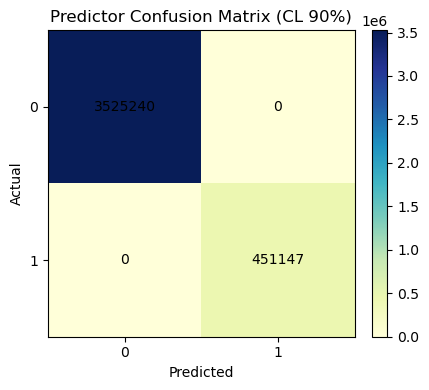

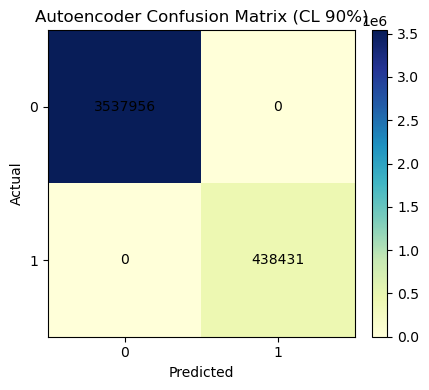

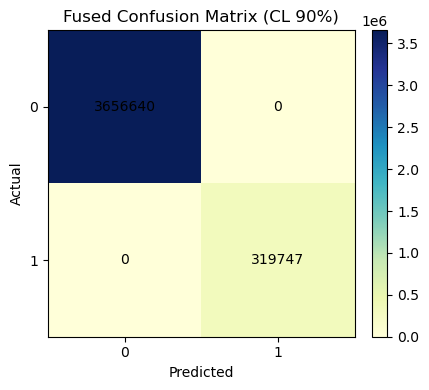

(319747, 0, 0, 3656640)

In [17]:
# =========================
# Confusion matrix heatmaps (matplotlib-only) for AE / Pred / Fused at CL=90%
# =========================
import numpy as np
import matplotlib.pyplot as plt
import os

LABEL_Q = 0.90    # proxy-label threshold
CL = 0.90         # confusion-matrix threshold for predictions

# --- Derive proxy labels per model ---
labels_pred  = (pred_val_cdf  >= LABEL_Q).astype(int)
labels_ae    = (ae_val_cdf    >= LABEL_Q).astype(int)
labels_fused = (fuse_val_cdf  >= LABEL_Q).astype(int)

def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def plot_confusion_matrix(name, scores, labels, q=0.90, save_path=None):
    # Threshold scores → predicted flags
    flags = (np.asarray(scores, dtype=float) >= q).astype(int)
    tp, fp, fn, tn = confusion_counts(flags, labels)

    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)   # rows: Actual 0/1, cols: Pred 0/1

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="YlGnBu")  # nicer colormap
    ax.set_xticks([0, 1]); ax.set_xticklabels(["0", "1"])
    ax.set_yticks([0, 1]); ax.set_yticklabels(["0", "1"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_title(f"{name} Confusion Matrix (CL {int(q*100)}%)")

    # annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

    return tp, fp, fn, tn

# Output dir
out_dir = "./figs"
os.makedirs(out_dir, exist_ok=True)

# Plot all three at CL=90%
plot_confusion_matrix("Predictor",   pred_val_cdf,  labels_pred,  q=CL,
                      save_path=os.path.join(out_dir, "predictor_confusion_matrix.png"))

plot_confusion_matrix("Autoencoder", ae_val_cdf,    labels_ae,    q=CL,
                      save_path=os.path.join(out_dir, "autoencoder_confusion_matrix.png"))

plot_confusion_matrix("Fused",       fuse_val_cdf,  labels_fused, q=CL,
                      save_path=os.path.join(out_dir, "fused_confusion_matrix.png"))


In [18]:
# =========================
# L) Persistence filter (min-run length on fused flags)
# =========================
MIN_RUN = 3  # keep anomalies that persist ≥3 consecutive windows

def persistence_filter(flags, mmsi_seq):
    # flags: (N,) 0/1 for fused_val_cdf>=CL
    # mmsi_seq: (N,) MMSI aligned to val windows (if you stored meta; else run per-MMSI later)
    # This simple variant assumes windows are already ordered per-MMSI and time.
    f = np.asarray(flags, dtype=int)
    keep = f.copy()
    run = 0
    for i in range(len(f)):
        if f[i] == 1:
            run += 1
        else:
            if run < MIN_RUN:
                keep[i-run:i] = 0
            run = 0
    if run < MIN_RUN:
        keep[len(f)-run:len(f)] = 0
    return keep

# If you have per-window MMSI/time meta, apply per MMSI; otherwise apply globally to maintain structure.
# Example (global quick pass w/o meta):
print("[FUSE] Persistence counts (runs ≥ MIN_RUN):")
for q in CLS:
    flags = (fuse_val_cdf >= q).astype(int)
    keep = persistence_filter(flags, None)
    print(f"  CL {int(q*100)}% → kept {keep.sum():,}/{len(keep):,}")


[FUSE] Persistence counts (runs ≥ MIN_RUN):
  CL 70% → kept 1,213,429/3,976,387
  CL 80% → kept 714,475/3,976,387
  CL 90% → kept 252,301/3,976,387
  CL 98% → kept 15,356/3,976,387


In [19]:
# =========================
# N) Kernel robustness check (quick)
# =========================
for kernel in ["gaussian", "tophat", "epanechnikov"]:
    kde = KernelDensity(kernel=kernel, bandwidth=_silverman_bandwidth(ae_train_scores)).fit(ae_train_scores[:,None])
    grid_k = grid  # reuse grid range from AE
    pdf_k = np.exp(kde.score_samples(grid_k[:,None]))
    dx = grid_k[1]-grid_k[0]
    cdf_k = np.cumsum(pdf_k)*dx; cdf_k /= max(cdf_k[-1], 1e-12)
    ae_val_cdf_k = np.interp(ae_val_scores, grid_k, cdf_k, left=0.0, right=1.0)
    print(f"[Kernel={kernel}] val flagged @CL90 = {(ae_val_cdf_k>=0.90).sum():,}")


[Kernel=gaussian] val flagged @CL90 = 438,431
[Kernel=tophat] val flagged @CL90 = 438,802
[Kernel=epanechnikov] val flagged @CL90 = 438,871


In [20]:
# =========================
# N) Kernel robustness check (AE / Predictor / Fused)
# =========================

for kernel in ["gaussian", "tophat", "epanechnikov"]:
    # --- Autoencoder ---
    kde_ae = KernelDensity(kernel=kernel, bandwidth=_silverman_bandwidth(ae_train_scores)).fit(ae_train_scores[:, None])
    pdf_ae = np.exp(kde_ae.score_samples(grid[:, None]))
    dx = grid[1] - grid[0]
    cdf_ae = np.cumsum(pdf_ae) * dx; cdf_ae /= max(cdf_ae[-1], 1e-12)
    ae_val_cdf_k = np.interp(ae_val_scores, grid, cdf_ae, left=0.0, right=1.0)

    # --- Predictor ---
    kde_pr = KernelDensity(kernel=kernel, bandwidth=_silverman_bandwidth(pred_train_scores)).fit(pred_train_scores[:, None])
    pdf_pr = np.exp(kde_pr.score_samples(grid_p[:, None]))
    dx_pr = grid_p[1] - grid_p[0]
    cdf_pr = np.cumsum(pdf_pr) * dx_pr; cdf_pr /= max(cdf_pr[-1], 1e-12)
    pr_val_cdf_k = np.interp(pred_val_scores, grid_p, cdf_pr, left=0.0, right=1.0)

    # --- Fused (just combine AE + Pred CDFs with FUSE_ALPHA) ---
    fuse_train_scores = FUSE_ALPHA * ae_train_cdf + (1.0 - FUSE_ALPHA) * pred_train_cdf
    fuse_val_scores   = FUSE_ALPHA * ae_val_cdf   + (1.0 - FUSE_ALPHA) * pred_val_cdf
    kde_fuse = KernelDensity(kernel=kernel, bandwidth=_silverman_bandwidth(fuse_train_scores)).fit(fuse_train_scores[:, None])
    grid_fuse = np.linspace(np.percentile(fuse_train_scores, 0.5), np.percentile(fuse_train_scores, 99.5), len(grid))
    pdf_fuse = np.exp(kde_fuse.score_samples(grid_fuse[:, None]))
    dx_fuse = grid_fuse[1] - grid_fuse[0]
    cdf_fuse = np.cumsum(pdf_fuse) * dx_fuse; cdf_fuse /= max(cdf_fuse[-1], 1e-12)
    fuse_val_cdf_k = np.interp(fuse_val_scores, grid_fuse, cdf_fuse, left=0.0, right=1.0)

    # --- Print results ---
    print(f"[Kernel={kernel}]")
    print(f"  AE    val flagged @CL90 = {(ae_val_cdf_k >= 0.90).sum():,}")
    print(f"  Pred  val flagged @CL90 = {(pr_val_cdf_k >= 0.90).sum():,}")
    print(f"  Fused val flagged @CL90 = {(fuse_val_cdf_k >= 0.90).sum():,}")


[Kernel=gaussian]
  AE    val flagged @CL90 = 438,431
  Pred  val flagged @CL90 = 451,147
  Fused val flagged @CL90 = 456,556
[Kernel=tophat]
  AE    val flagged @CL90 = 438,802
  Pred  val flagged @CL90 = 451,421
  Fused val flagged @CL90 = 456,760
[Kernel=epanechnikov]
  AE    val flagged @CL90 = 438,871
  Pred  val flagged @CL90 = 451,509
  Fused val flagged @CL90 = 457,292


In [21]:
# =========================
# N) Kernel robustness + threshold calibration + persistence filtering
# =========================
from sklearn.neighbors import KernelDensity
import numpy as np

# --- Config ---
CLS = (0.70, 0.80, 0.90, 0.98)
MIN_RUN = 3   # require ≥3 consecutive anomalous windows
# Optional: set VAL_MMSI to a 1D array of MMSI (string/int) aligned to your validation windows
# VAL_MMSI = np.array([...])  # optional; if not present, filtering is global

# --- Helpers (reuse your Silverman; define a safe persistence) ---
def _silverman_bandwidth(x):
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    n = max(len(x), 1)
    if n < 2: return 1.0
    std = np.std(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = min(std, iqr / 1.349) if iqr > 0 else std
    if sigma <= 0: sigma = std if std > 0 else 1.0
    return 0.9 * sigma * n ** (-1/5)

def fit_kde_cdf(train_vals, grid_like):
    train_vals = np.asarray(train_vals, dtype=float)
    train_vals = train_vals[np.isfinite(train_vals)]
    if train_vals.size == 0:
        raise RuntimeError("No finite training values for KDE.")
    bw = _silverman_bandwidth(train_vals)
    # Use a grid similar in span/count to the provided reference
    lo, hi = np.percentile(train_vals, [0.5, 99.5])
    pad = 0.25 * (hi - lo + 1e-9)
    lo, hi = float(lo - pad), float(hi + pad)
    grid_k = np.linspace(lo, hi, len(grid_like))
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(train_vals[:, None])
    pdf = np.exp(kde.score_samples(grid_k[:, None]))
    dx = grid_k[1] - grid_k[0]
    cdf = np.cumsum(pdf) * dx
    cdf /= max(cdf[-1], 1e-12)
    return grid_k, cdf

def map_to_cdf(vals, grid_k, cdf_k):
    return np.interp(np.asarray(vals, dtype=float), grid_k, cdf_k, left=0.0, right=1.0)

def apply_persistence(flags, mmsi_seq=None, min_run=3):
    """
    flags: 1D int array of 0/1
    mmsi_seq: 1D sequence of MMSI aligned to flags; if provided, enforce runs within each MMSI
    """
    f = np.asarray(flags, dtype=int)
    keep = np.zeros_like(f)
    if mmsi_seq is None:
        # global pass
        run = 0
        for i in range(len(f)):
            if f[i] == 1:
                run += 1
            else:
                if run >= min_run:
                    keep[i-run:i] = 1
                run = 0
        if run >= min_run:
            keep[len(f)-run:len(f)] = 1
        return keep
    else:
        # per-MMSI pass
        m = np.asarray(mmsi_seq)
        # assume already time-ordered; if not, sort first in your data prep
        start = 0
        for i in range(1, len(f)+1):
            if i == len(f) or m[i] != m[start]:
                # process segment [start, i)
                seg = f[start:i]
                run = 0
                for j in range(len(seg)):
                    if seg[j] == 1:
                        run += 1
                    else:
                        if run >= min_run:
                            keep[start + j - run : start + j] = 1
                        run = 0
                if run >= min_run:
                    keep[start + len(seg) - run : start + len(seg)] = 1
                start = i
        return keep

# --- Pre-requisites from your earlier blocks (assumed already computed) ---
# ae_train_scores, ae_val_scores, grid               # AE errors + grid
# pred_train_scores, pred_val_scores, grid_p         # Pred errors + grid
# ae_train_cdf, ae_val_cdf, pred_train_cdf, pred_val_cdf  # CDF scores
# FUSE_ALPHA

# Fused scores (existing convex combo in [0,1])
fuse_train_scores = FUSE_ALPHA*ae_train_cdf + (1.0 - FUSE_ALPHA)*pred_train_cdf
fuse_val_scores   = FUSE_ALPHA*ae_val_cdf   + (1.0 - FUSE_ALPHA)*pred_val_cdf

# If you have per-window MMSI aligned to the *validation* windows, set mmsi_val here (optional)
mmsi_val = None
try:
    mmsi_val = VAL_MMSI  # if you prepared this elsewhere
except NameError:
    mmsi_val = None  # falls back to global filtering

# --- Main loop: per kernel → fit KDE/CDF → map val → threshold sweep → persistence ---
for kernel in ["gaussian", "tophat", "epanechnikov"]:
    # AE: fit on train errors, map val errors
    grid_ae_k, cdf_ae_k = fit_kde_cdf(ae_train_scores, grid)
    ae_val_cdf_k = map_to_cdf(ae_val_scores, grid_ae_k, cdf_ae_k)

    # Pred: fit on train errors, map val errors
    grid_pr_k, cdf_pr_k = fit_kde_cdf(pred_train_scores, grid_p)
    pr_val_cdf_k = map_to_cdf(pred_val_scores, grid_pr_k, cdf_pr_k)

    # Fused: fit on fused train scores, map fused val scores
    # (scores are already in [0,1]; we build a kernel-specific CDF for robustness testing)
    # Use AE grid length for consistency
    grid_fu_k, cdf_fu_k = fit_kde_cdf(fuse_train_scores, grid)
    fu_val_cdf_k = map_to_cdf(fuse_val_scores, grid_fu_k, cdf_fu_k)

    print(f"\n[Kernel={kernel}] Threshold sweep with persistence (MIN_RUN={MIN_RUN})")
    for q in CLS:
        k = int(q*100)
        # AE
        flags_ae = (ae_val_cdf_k >= q).astype(int)
        kept_ae  = apply_persistence(flags_ae, mmsi_seq=mmsi_val, min_run=MIN_RUN)
        # Pred
        flags_pr = (pr_val_cdf_k >= q).astype(int)
        kept_pr  = apply_persistence(flags_pr, mmsi_seq=mmsi_val, min_run=MIN_RUN)
        # Fused
        flags_fu = (fu_val_cdf_k >= q).astype(int)
        kept_fu  = apply_persistence(flags_fu, mmsi_seq=mmsi_val, min_run=MIN_RUN)

        # Print counts and reduction percentages
        def _fmt(before, after):
            red = 0.0 if before == 0 else 100.0*(before - after)/before
            return f"{after:,}/{before:,} kept ({red:.1f}% fewer)"
        print(f"  CL {k}% → AE:    {_fmt(flags_ae.sum(), kept_ae.sum())}")
        print(f"            Pred:  {_fmt(flags_pr.sum(), kept_pr.sum())}")
        print(f"            Fused: {_fmt(flags_fu.sum(), kept_fu.sum())}")



[Kernel=gaussian] Threshold sweep with persistence (MIN_RUN=3)
  CL 70% → AE:    1,188,181/1,285,055 kept (7.5% fewer)
            Pred:  1,204,171/1,301,859 kept (7.5% fewer)
            Fused: 1,201,880/1,291,607 kept (6.9% fewer)
  CL 80% → AE:    762,234/862,291 kept (11.6% fewer)
            Pred:  781,625/881,066 kept (11.3% fewer)
            Fused: 775,588/868,267 kept (10.7% fewer)
  CL 90% → AE:    355,641/438,431 kept (18.9% fewer)
            Pred:  369,378/451,147 kept (18.1% fewer)
            Fused: 364,541/441,342 kept (17.4% fewer)
  CL 98% → AE:    69,920/102,091 kept (31.5% fewer)
            Pred:  62,311/95,789 kept (34.9% fewer)
            Fused: 57,909/89,450 kept (35.3% fewer)

[Kernel=tophat] Threshold sweep with persistence (MIN_RUN=3)
  CL 70% → AE:    1,188,357/1,285,225 kept (7.5% fewer)
            Pred:  1,204,251/1,301,943 kept (7.5% fewer)
            Fused: 1,201,748/1,291,478 kept (6.9% fewer)
  CL 80% → AE:    762,598/862,637 kept (11.6% fewer)
   

In [32]:
# ==========================================
# Multi-objective optimization: Precision, Recall, Latency
# ==========================================
import numpy as np
import pandas as pd
import random

# -------- Inputs expected from your session --------
# ae_val_cdf, pred_val_cdf : np.ndarray in [0,1]  (validation window scores)
# Optional: VAL_MMSI       : aligned MMSI array for val windows (np.ndarray of str/int)
# Config already defined:  WIN_STRIDE, DEFAULT_DT_MIN

# If you have per-window MMSI aligned to validation windows, set here (else leave as None)
try:
    mmsi_val = VAL_MMSI
except NameError:
    mmsi_val = None

# -------- Helper: persistence filter (per-MMSI if provided) --------
def apply_persistence(flags, mmsi_seq=None, min_run=3):
    f = np.asarray(flags, dtype=int)
    keep = np.zeros_like(f)
    if mmsi_seq is None:
        run = 0
        for i in range(len(f)):
            if f[i] == 1:
                run += 1
            else:
                if run >= min_run:
                    keep[i-run:i] = 1
                run = 0
        if run >= min_run:
            keep[len(f)-run:len(f)] = 1
        return keep
    else:
        m = np.asarray(mmsi_seq)
        start = 0
        for i in range(1, len(f)+1):
            if i == len(f) or m[i] != m[start]:
                seg = f[start:i]
                run = 0
                for j in range(len(seg)):
                    if seg[j] == 1:
                        run += 1
                    else:
                        if run >= min_run:
                            keep[start + j - run : start + j] = 1
                        run = 0
                if run >= min_run:
                    keep[start + len(seg) - run : start + len(seg)] = 1
                start = i
        return keep

# -------- Helper: metrics --------
def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec / max(prec + rec, 1e-12)) if (prec + rec) > 0 else 0.0
    fpr  = fp / max(fp + tn, 1)
    acc  = (tp + tn) / max(tp + fp + fn + tn, 1)
    return prec, rec, f1, fpr, acc

# -------- Latency model --------
# Base inference latency per window (ms). If unknown, keep 0; the MIN_RUN delay dominates.
BASE_INFER_MS = 0.0

def detection_latency_seconds(min_run, win_stride=10, dt_min=2, base_infer_ms=0.0):
    # time until an anomaly can be confirmed under persistence (min_run windows)
    confirm_delay = max(min_run - 1, 0) * win_stride * dt_min * 60.0  # seconds
    return confirm_delay + (base_infer_ms / 1000.0)

# -------- Labels (choose which proxy to optimize against) --------
# You asked to optimize Precision/Recall/Latency. For labels, pick one of: 'fused', 'pred', 'ae'
LABEL_SOURCE = 'fused'  # <- change to 'pred' or 'ae' if you prefer that proxy

if LABEL_SOURCE == 'fused':
    # start with equal alpha for proxy label definition
    labels_proxy = ((0.5 * ae_val_cdf + 0.5 * pred_val_cdf) >= 0.90).astype(int)
elif LABEL_SOURCE == 'pred':
    labels_proxy = (pred_val_cdf >= 0.90).astype(int)
elif LABEL_SOURCE == 'ae':
    labels_proxy = (ae_val_cdf >= 0.90).astype(int)
else:
    raise ValueError("LABEL_SOURCE must be 'fused', 'pred', or 'ae'.")

# -------- Decision variables & search space --------
# q: threshold in [0.70, 0.99]
# alpha: fusion weight in [0.0, 1.0]
# min_run: integer in [1, 6]
Q_GRID      = np.linspace(0.70, 0.99, 20)       # 20 thresholds
ALPHA_GRID  = np.linspace(0.0, 1.0, 21)         # 0.00 .. 1.00 (step 0.05)
MINRUN_SET  = list(range(1, 7))                 # 1..6

# You can switch to random sampling for larger space:
USE_RANDOM = True
N_RANDOM   = 200  # number of random candidates

def sample_candidates():
    if not USE_RANDOM:
        for q in Q_GRID:
            for a in ALPHA_GRID:
                for r in MINRUN_SET:
                    yield float(q), float(a), int(r)
    else:
        for _ in range(N_RANDOM):
            q = float(np.random.uniform(0.70, 0.99))
            a = float(np.random.uniform(0.0, 1.0))
            r = int(np.random.randint(1, 7))
            yield q, a, r

# -------- Evaluate a candidate --------
def evaluate_candidate(q, alpha, min_run):
    # Fused score from AE & Pred CDFs
    s = alpha * ae_val_cdf + (1.0 - alpha) * pred_val_cdf
    flags = (s >= q).astype(int)
    flags_kept = apply_persistence(flags, mmsi_seq=mmsi_val, min_run=min_run)

    tp, fp, fn, tn = confusion_counts(flags_kept, labels_proxy)
    prec, rec, f1, fpr, acc = metrics_from_counts(tp, fp, fn, tn)
    latency_s = detection_latency_seconds(min_run, WIN_STRIDE, DEFAULT_DT_MIN, BASE_INFER_MS)

    return {
        "q": q, "alpha": alpha, "min_run": min_run,
        "precision": prec, "recall": rec, "f1": f1, "fpr": fpr, "acc": acc,
        "latency_s": latency_s,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "flagged": int(flags.sum()), "kept": int(flags_kept.sum())
    }

# -------- Run search --------
rows = []
for (q, a, r) in sample_candidates():
    rows.append(evaluate_candidate(q, a, r))
results = pd.DataFrame(rows).sort_values(["f1"], ascending=False).reset_index(drop=True)

# -------- Pareto front (maximize precision & recall, minimize latency) --------
def dominates(x, y):
    # x dominates y if x is >= on precision/recall and <= on latency, and strictly better in at least one
    better_or_equal = (x["precision"] >= y["precision"]) and (x["recall"] >= y["recall"]) and (x["latency_s"] <= y["latency_s"])
    strictly_better = (x["precision"] > y["precision"]) or (x["recall"] > y["recall"]) or (x["latency_s"] < y["latency_s"])
    return better_or_equal and strictly_better

def pareto_front(df):
    idxs = df.index.tolist()
    is_dominated = {i: False for i in idxs}
    for i in idxs:
        if is_dominated[i]:
            continue
        xi = df.loc[i]
        for j in idxs:
            if i == j or is_dominated[i]:
                continue
            xj = df.loc[j]
            if dominates(xj, xi):
                is_dominated[i] = True
    front = df.loc[[i for i in idxs if not is_dominated[i]]].copy()
    return front

front = pareto_front(results)

# -------- Pick representative configurations --------
# Balanced = maximize f1 among front
balanced = front.sort_values(["f1","precision","recall"], ascending=[False,False,False]).head(1)

# High-recall = among front, highest recall; tie-breaker: precision then latency
high_recall = front.sort_values(["recall","precision","latency_s"], ascending=[False,False,True]).head(1)

# Low-latency (fastest confirmation) = among front, lowest latency; tie-breaker: f1 then precision
low_latency = front.sort_values(["latency_s","f1","precision"], ascending=[True,False,False]).head(1)

print("\n=== Multi-objective search complete ===")
print(f"Total candidates: {len(results)}  |  Pareto front size: {len(front)}")
print("\nBalanced pick (highest F1 on Pareto front):")
print(balanced[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])

print("\nHigh-recall pick:")
print(high_recall[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])

print("\nLow-latency pick:")
print(low_latency[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])

# (Optional) Save for your Results chapter
try:
    results.to_csv("./cache_streaming/moo_candidates.csv", index=False)
    front.to_csv("./cache_streaming/moo_pareto_front.csv", index=False)
    print("\nSaved: ./cache_streaming/moo_candidates.csv and ./cache_streaming/moo_pareto_front.csv")
except Exception as e:
    print("\n[warn] Could not save CSVs:", e)



=== Multi-objective search complete ===
Total candidates: 200  |  Pareto front size: 9

Balanced pick (highest F1 on Pareto front):
          q     alpha  min_run  precision   recall        f1  latency_s  \
0  0.897193  0.362576        1   0.876509  0.95316  0.913229        0.0   

        fpr    kept  
0  0.011743  347709  

High-recall pick:
           q     alpha  min_run  precision  recall        f1  latency_s  \
17  0.858667  0.678854        1   0.607764     1.0  0.756036        0.0   

         fpr    kept  
17  0.056434  526104  

Low-latency pick:
          q     alpha  min_run  precision   recall        f1  latency_s  \
0  0.897193  0.362576        1   0.876509  0.95316  0.913229        0.0   

        fpr    kept  
0  0.011743  347709  

Saved: ./cache_streaming/moo_candidates.csv and ./cache_streaming/moo_pareto_front.csv


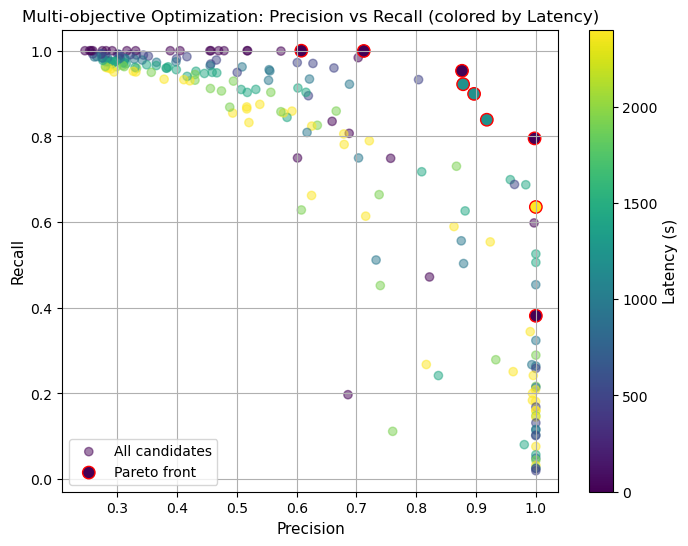

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(results["precision"], results["recall"], c=results["latency_s"], 
            cmap="viridis", alpha=0.5, label="All candidates")
plt.scatter(front["precision"], front["recall"], c=front["latency_s"], 
            cmap="viridis", edgecolors="red", s=80, label="Pareto front", marker="o")

plt.colorbar(label="Latency (s)")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Multi-objective Optimization: Precision vs Recall (colored by Latency)")
plt.legend()
plt.grid(True)
plt.show()


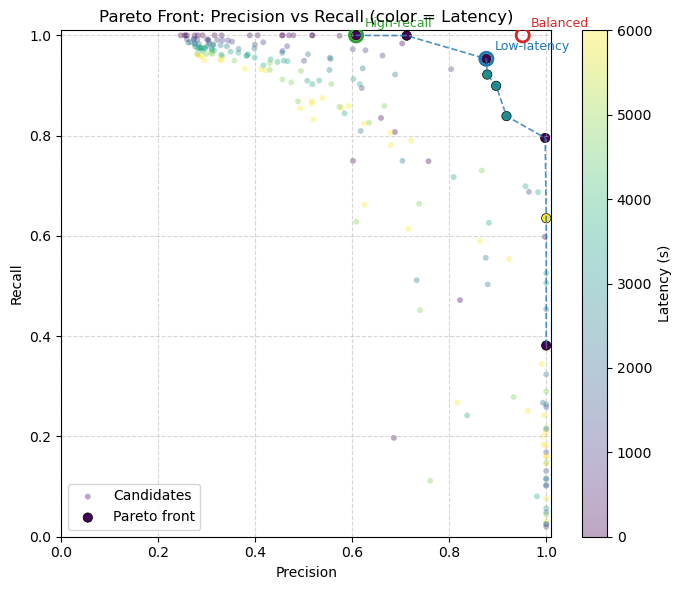

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --- safety: ensure front is unique and sorted so the line connects left→right
front_plot = (front
              .drop_duplicates(subset=["precision","recall","latency_s"])
              .sort_values(["precision","recall"], ascending=[True, False]))

fig, ax = plt.subplots(figsize=(7,6))

# 1) All explored candidates (the “leverages”): faint points
sc_all = ax.scatter(results["precision"], results["recall"],
                    c=results["latency_s"], s=18, alpha=0.35,
                    cmap="viridis", edgecolors="none", label="Candidates")

# 2) Pareto front (non-dominated): highlighted + connected curve
ax.scatter(front_plot["precision"], front_plot["recall"],
           c=front_plot["latency_s"], s=45, cmap="viridis",
           edgecolors="black", linewidths=0.5, label="Pareto front")
ax.plot(front_plot["precision"], front_plot["recall"],
        linestyle="--", linewidth=1.2, alpha=0.8)

# 3) Annotate representative picks (if you computed them)
def _ann(pt, name, color="crimson"):
    x, y = float(pt["precision"]), float(pt["recall"])
    ax.scatter([x],[y], s=90, facecolors="none", edgecolors=color, linewidths=2, zorder=5)
    ax.annotate(name, (x, y), textcoords="offset points", xytext=(6,6), fontsize=9, color=color)

if len(balanced):   _ann(balanced.iloc[0],   "Balanced",   "#d62728")
if len(high_recall):_ann(high_recall.iloc[0],"High-recall","#2ca02c")
if len(low_latency):_ann(low_latency.iloc[0],"Low-latency","#1f77b4")

# Axes/labels
ax.set_title("Pareto Front: Precision vs Recall (color = Latency)", fontsize=12)
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_xlim(0, 1.01); ax.set_ylim(0, 1.01)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar for latency
cbar = plt.colorbar(sc_all, ax=ax)
cbar.set_label("Latency (s)")

ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig("pareto_precision_recall_latency.png", dpi=300)
plt.show()


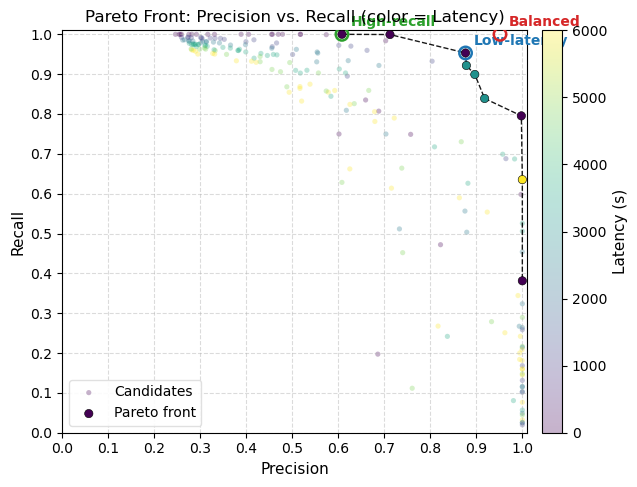

In [37]:
# ---- PARETO FRONT: Precision–Recall colored by Latency (Dissertation version) ----
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# A. Prepare front for plotting (unique + sorted so the line connects left→right)
front_plot = (front
              .drop_duplicates(subset=["precision","recall","latency_s"])
              .sort_values(["precision","recall"], ascending=[True, False]))

# B. Figure aesthetics (journal-like)
plt.rcParams.update({
    "figure.figsize": (6.5, 5.0),
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

fig, ax = plt.subplots()

# 1) All explored candidates (faint swarm)
sc_all = ax.scatter(results["precision"], results["recall"],
                    c=results["latency_s"], s=14, alpha=0.30,
                    cmap="viridis", edgecolors="none", label="Candidates")

# 2) Pareto front (non-dominated) highlighted + connected curve
pf = ax.scatter(front_plot["precision"], front_plot["recall"],
                c=front_plot["latency_s"], s=36, cmap="viridis",
                edgecolors="black", linewidths=0.4, zorder=3, label="Pareto front")
ax.plot(front_plot["precision"], front_plot["recall"],
        linestyle="--", linewidth=1.0, alpha=0.9, color="k", zorder=2)

# 3) Annotate representative picks (optional but useful in Discussion)
def _ann(row, name, color):
    x, y = float(row["precision"]), float(row["recall"])
    ax.scatter([x],[y], s=80, facecolors="none", edgecolors=color, linewidths=1.8, zorder=4)
    ax.annotate(name, (x, y), xytext=(6,6), textcoords="offset points",
                fontsize=10, color=color, weight="bold")

if len(balanced):    _ann(balanced.iloc[0],    "Balanced",    "#d62728")
if len(high_recall): _ann(high_recall.iloc[0], "High-recall", "#2ca02c")
if len(low_latency): _ann(low_latency.iloc[0], "Low-latency", "#1f77b4")

# Axes & ticks
ax.set_title("Pareto Front: Precision vs. Recall (color = Latency)")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_xlim(0.0, 1.01); ax.set_ylim(0.0, 1.01)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.grid(True, linestyle="--", alpha=0.45)
leg = ax.legend(loc="lower left", frameon=True, framealpha=0.9, edgecolor="#dddddd")

# Colorbar (latency in seconds)
cbar = plt.colorbar(sc_all, ax=ax, fraction=0.046, pad=0.03)
cbar.set_label("Latency (s)")

plt.tight_layout()

# C. Save both vector and bitmap for thesis/journal
plt.savefig("fig_pareto_pr_latency.pdf")         # vector (preferred in LaTeX)
plt.savefig("fig_pareto_pr_latency.png", dpi=600) # high-res bitmap (for Word)
# plt.show()  # uncomment if running interactively



Pareto front configurations:
          q     alpha  min_run  precision    recall        f1  latency_s  \
0  0.896263  0.482521        2   0.958391  0.902829  0.929781     1200.0   
1  0.904061  0.474174        2   0.999489  0.837972  0.911632     1200.0   
3  0.887066  0.421704        2   0.854984  0.928753  0.890343     1200.0   
5  0.885173  0.397594        1   0.801599  0.997670  0.888951        0.0   
6  0.881992  0.584314        1   0.792742  1.000000  0.884391        0.0   
7  0.916807  0.502720        1   1.000000  0.767300  0.868330        0.0   

        fpr    kept  
0  0.003427  301210  
1  0.000037  268076  
3  0.013775  347335  
5  0.021592  397957  
6  0.022861  403343  
7  0.000000  245342  


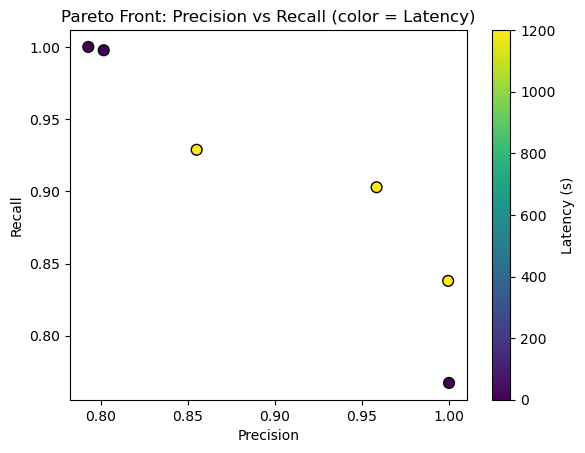

In [29]:
# === Show Pareto front results ===
print("\nPareto front configurations:")
print(front[["q", "alpha", "min_run", "precision", "recall", "f1", "latency_s", "fpr", "kept"]])

# Optionally save just the Pareto front
front.to_csv("./cache_streaming/pareto_front_only.csv", index=False)

# If you want to plot Precision vs Recall (color by latency)
import matplotlib.pyplot as plt

plt.scatter(front["precision"], front["recall"], c=front["latency_s"], cmap="viridis", s=60, edgecolor="k")
plt.colorbar(label="Latency (s)")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Pareto Front: Precision vs Recall (color = Latency)")
plt.show()


[NSGA-II] Gen 5/50 | max P=1.000, max R=0.986, min Lat=1200.0s
[NSGA-II] Gen 10/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 15/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 20/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 25/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 30/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 35/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 40/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 45/50 | max P=1.000, max R=0.988, min Lat=1200.0s
[NSGA-II] Gen 50/50 | max P=1.000, max R=0.988, min Lat=1200.0s

=== NSGA-II complete ===
Population: 100  |  Pareto front size: 100
           q     alpha  min_run  precision    recall        f1  latency_s  \
63  0.889650  0.970170        2   0.937615  0.917371  0.927383     1200.0   
96  0.889798  0.958618        2   0.940749  0.913352  0.926848     1200.0   
60  0.889798  0.958588        2   0.940755  0.913339  0.92684

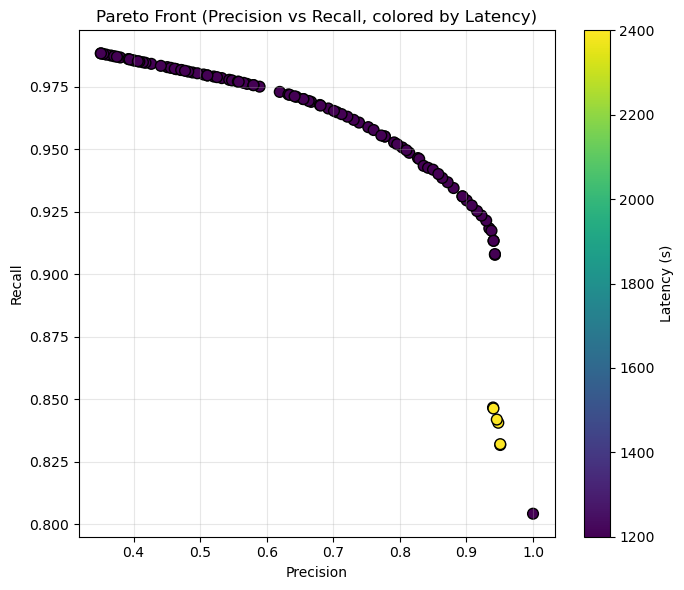

In [28]:
# ==========================================
# NSGA-II (patched): decoupled labels, q-band exclusion, MIN_RUN floor, + optional FPR objective
# ==========================================
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# --- Knobs (adjust here) ---
LABEL_SOURCE = 'ae'          # 'ae' | 'pred' | 'fused'  (decouple labels from fused optimization)
LABEL_Q = 0.90               # proxy cut for labels
FORBID_Q_BAND = (0.89, 0.91) # avoid identity w/ label cut
MIN_RUN_MIN = 2              # enforce persistence >= 2 to avoid zero-latency tautology
ADD_FPR_OBJECTIVE = True     # add FPR as a 4th objective (minimize) to break ties
BASE_INFER_MS = 0.0          # if you profiled model latency per window, set here

# --- Inputs assumed present from your session ---
# ae_val_cdf, pred_val_cdf, WIN_STRIDE, DEFAULT_DT_MIN
try:
    mmsi_val = VAL_MMSI
except NameError:
    mmsi_val = None

# --- Label choice (decoupled from fused optimization) ---
if LABEL_SOURCE == 'fused':
    labels_proxy = ((0.5 * ae_val_cdf + 0.5 * pred_val_cdf) >= LABEL_Q).astype(int)
elif LABEL_SOURCE == 'pred':
    labels_proxy = (pred_val_cdf >= LABEL_Q).astype(int)
elif LABEL_SOURCE == 'ae':
    labels_proxy = (ae_val_cdf >= LABEL_Q).astype(int)
else:
    raise ValueError("LABEL_SOURCE must be 'ae', 'pred', or 'fused'.")

# --- Helpers reused from your session ---
def apply_persistence(flags, mmsi_seq=None, min_run=3):
    f = np.asarray(flags, dtype=int)
    keep = np.zeros_like(f)
    if mmsi_seq is None:
        run = 0
        for i in range(len(f)):
            if f[i] == 1:
                run += 1
            else:
                if run >= min_run:
                    keep[i-run:i] = 1
                run = 0
        if run >= min_run:
            keep[len(f)-run:len(f)] = 1
        return keep
    else:
        m = np.asarray(mmsi_seq)
        start = 0
        for i in range(1, len(f)+1):
            if i == len(f) or m[i] != m[start]:
                seg = f[start:i]
                run = 0
                for j in range(len(seg)):
                    if seg[j] == 1:
                        run += 1
                    else:
                        if run >= min_run:
                            keep[start + j - run : start + j] = 1
                        run = 0
                if run >= min_run:
                    keep[start + len(seg) - run : start + len(seg)] = 1
                start = i
        return keep

def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec / max(prec + rec, 1e-12)) if (prec + rec) > 0 else 0.0
    fpr  = fp / max(fp + tn, 1)
    acc  = (tp + tn) / max(tp + fp + fn + tn, 1)
    return prec, rec, f1, fpr, acc

def detection_latency_seconds(min_run, win_stride, dt_min, base_infer_ms=0.0):
    return max(min_run - 1, 0) * win_stride * dt_min * 60.0 + base_infer_ms/1000.0

# --- Decision variables & bounds ---
# x = [q, alpha, min_run_real]
LB = np.array([0.70, 0.0, float(MIN_RUN_MIN)], dtype=float)
UB = np.array([0.99, 1.0, 6.0], dtype=float)

def clamp(x): return np.minimum(UB, np.maximum(LB, x))
def round_minrun(v): return int(np.clip(int(round(v)), MIN_RUN_MIN, 6))
def fused_scores(alpha): return alpha*ae_val_cdf + (1.0 - alpha)*pred_val_cdf

# --- Evaluation (with q-band exclusion + optional FPR objective) ---
def evaluate(x):
    q, alpha, mr = float(x[0]), float(x[1]), round_minrun(x[2])

    # forbid trivial band near proxy cut
    if FORBID_Q_BAND[0] <= q <= FORBID_Q_BAND[1]:
        pen = 1e6
        objs = [pen, pen, pen] + ([pen] if ADD_FPR_OBJECTIVE else [])
        return np.array(objs, float), {
            "q": q, "alpha": alpha, "min_run": mr,
            "precision": 0.0, "recall": 0.0, "f1": 0.0, "fpr": 1.0, "acc": 0.0,
            "latency_s": detection_latency_seconds(mr, WIN_STRIDE, DEFAULT_DT_MIN, BASE_INFER_MS),
            "tp": 0, "fp": 0, "fn": 0, "tn": 0, "flagged": 0, "kept": 0
        }

    s = fused_scores(alpha)
    flags = (s >= q).astype(int)
    kept  = apply_persistence(flags, mmsi_seq=mmsi_val, min_run=mr)

    tp, fp, fn, tn = confusion_counts(kept, labels_proxy)
    prec, rec, f1, fpr, acc = metrics_from_counts(tp, fp, fn, tn)
    lat_s = detection_latency_seconds(mr, WIN_STRIDE, DEFAULT_DT_MIN, BASE_INFER_MS)

    objs = [-prec, -rec, lat_s]
    if ADD_FPR_OBJECTIVE:
        objs.append(fpr)

    info = {
        "q": q, "alpha": alpha, "min_run": mr,
        "precision": prec, "recall": rec, "f1": f1, "fpr": fpr, "acc": acc,
        "latency_s": lat_s, "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "flagged": int(flags.sum()), "kept": int(kept.sum())
    }
    return np.array(objs, float), info

# --- NSGA-II operators (same as before) ---
def fast_non_dominated_sort(F):
    N = F.shape[0]
    S = [[] for _ in range(N)]
    n = np.zeros(N, dtype=int)
    ranks = np.zeros(N, dtype=int)
    fronts = [[]]

    def dominates(i, j):
        return np.all(F[i] <= F[j]) and np.any(F[i] < F[j])

    for p in range(N):
        for q in range(N):
            if p == q: continue
            if dominates(p, q):
                S[p].append(q)
            elif dominates(q, p):
                n[p] += 1
        if n[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    ranks[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    fronts.pop()
    return fronts, ranks

def crowding_distance(F, front_idx):
    if len(front_idx) == 0: return np.array([])
    M = F.shape[1]
    d = np.zeros(len(front_idx), dtype=float)
    if len(front_idx) <= 2:
        d.fill(np.inf); return d
    for m in range(M):
        vals = F[front_idx, m]
        order = np.argsort(vals)
        d[order[0]]  = np.inf
        d[order[-1]] = np.inf
        vmin, vmax = vals[order[0]], vals[order[-1]]
        denom = (vmax - vmin) if (vmax - vmin) > 0 else 1.0
        for k in range(1, len(front_idx)-1):
            prev_v = vals[order[k-1]]
            next_v = vals[order[k+1]]
            d[order[k]] += (next_v - prev_v) / denom
    return d

def tournament_select(pop, F, ranks):
    i, j = np.random.randint(0, len(pop)), np.random.randint(0, len(pop))
    if ranks[i] < ranks[j]: return i
    if ranks[j] < ranks[i]: return j
    return i if random.random() < 0.5 else j

def sbx_crossover(p1, p2, eta=15.0, prob=0.9):
    if random.random() > prob: return p1.copy(), p2.copy()
    c1, c2 = p1.copy(), p2.copy()
    for d in range(len(p1)):
        if random.random() < 0.5:
            x1, x2 = p1[d], p2[d]
            if abs(x1 - x2) < 1e-12: continue
            xl, xu = LB[d], UB[d]
            if x1 > x2: x1, x2 = x2, x1
            beta = 1.0 + (2.0*(x1 - xl) / (x2 - x1)); alpha = 2.0 - beta ** (-(eta + 1.0))
            rand = random.random()
            betaq = (rand * alpha) ** (1.0 / (eta + 1.0)) if rand <= 1.0/alpha else (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c1d = 0.5 * ((x1 + x2) - betaq * (x2 - x1))
            beta = 1.0 + (2.0*(xu - x2) / (x2 - x1)); alpha = 2.0 - beta ** (-(eta + 1.0))
            betaq = (rand * alpha) ** (1.0 / (eta + 1.0)) if rand <= 1.0/alpha else (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c2d = 0.5 * ((x1 + x2) + betaq * (x2 - x1))
            c1[d] = np.clip(c1d, LB[d], UB[d]); c2[d] = np.clip(c2d, LB[d], UB[d])
    return c1, c2

def poly_mutation(x, eta=20.0, prob=0.2):
    y = x.copy()
    for d in range(len(x)):
        if random.random() < prob:
            xl, xu = LB[d], UB[d]
            if abs(xu - xl) < 1e-12: continue
            delta1 = (y[d] - xl) / (xu - xl)
            delta2 = (xu - y[d]) / (xu - xl)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.0)
            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0*rand + (1.0 - 2.0*rand)*(xy ** (eta + 1.0))
                deltaq = (val ** mut_pow) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0 - rand) + 2.0*(rand - 0.5)*(xy ** (eta + 1.0))
                deltaq = 1.0 - (val ** mut_pow)
            y[d] = np.clip(y[d] + deltaq * (xu - xl), xl, xu)
    return y

def nsga2(pop_size=100, generations=50, cx_prob=0.9, mut_prob=0.2, seed=42):
    random.seed(seed); np.random.seed(seed)
    pop = [np.array([np.random.uniform(LB[0], UB[0]),
                     np.random.uniform(LB[1], UB[1]),
                     np.random.uniform(LB[2], UB[2])], dtype=float)
           for _ in range(pop_size)]

    def evaluate_pop(pop):
        Fs, infos = [], []
        for x in pop:
            f, info = evaluate(x)
            Fs.append(f); infos.append(info)
        return np.vstack(Fs), infos

    F, infos = evaluate_pop(pop)

    for gen in range(generations):
        fronts, ranks = fast_non_dominated_sort(F)
        crowd = np.zeros(len(pop), dtype=float)
        for fr in fronts:
            d = crowding_distance(F, fr)
            for k, idx in enumerate(fr): crowd[idx] = d[k]

        # parent selection
        parents = []
        while len(parents) < pop_size:
            i = tournament_select(pop, F, ranks)
            j = tournament_select(pop, F, ranks)
            parents.append(pop[i].copy()); parents.append(pop[j].copy())
        parents = parents[:pop_size]

        # variation
        offspring = []
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[(i+1) % pop_size]
            c1, c2 = sbx_crossover(p1, p2, prob=cx_prob)
            c1 = poly_mutation(c1, prob=mut_prob); c2 = poly_mutation(c2, prob=mut_prob)
            offspring.append(clamp(c1)); offspring.append(clamp(c2))
        offspring = offspring[:pop_size]

        F_off, infos_off = evaluate_pop(offspring)

        # environmental selection
        pop2 = pop + offspring
        F2   = np.vstack([F, F_off])
        fronts2, _ = fast_non_dominated_sort(F2)

        new_pop, new_F, new_infos = [], [], []
        for fr in fronts2:
            if len(new_pop) + len(fr) <= pop_size:
                for idx in fr:
                    new_pop.append(pop2[idx]); new_F.append(F2[idx])
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
            else:
                d = crowding_distance(F2, fr)
                order = np.argsort(-d)
                need = pop_size - len(new_pop)
                for t in order[:need]:
                    idx = fr[t]
                    new_pop.append(pop2[idx]); new_F.append(F2[idx])
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
                break

        pop, F, infos = new_pop, np.vstack(new_F), new_infos

        if (gen+1) % 5 == 0 or gen == generations-1:
            best_prec = max(inf["precision"] for inf in infos)
            best_rec  = max(inf["recall"]   for inf in infos)
            min_lat   = min(inf["latency_s"] for inf in infos)
            print(f"[NSGA-II] Gen {gen+1}/{generations} | max P={best_prec:.3f}, max R={best_rec:.3f}, min Lat={min_lat:.1f}s")

    fronts, _ = fast_non_dominated_sort(F)
    pareto_idx = fronts[0]
    df_front = pd.DataFrame([infos[i] for i in pareto_idx])
    df_all   = pd.DataFrame(infos)

    print("\n=== NSGA-II complete ===")
    print(f"Population: {len(pop)}  |  Pareto front size: {len(df_front)}")
    print(df_front.sort_values(['f1','precision','recall'], ascending=[False,False,False]).head(3)[
        ["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]
    ])

    # Save
    try:
        df_all.to_csv("./cache_streaming/nsga2_population.csv", index=False)
        df_front.to_csv("./cache_streaming/nsga2_pareto_front.csv", index=False)
        print("Saved: nsga2_population.csv, nsga2_pareto_front.csv")
    except Exception as e:
        print("[warn] Could not save CSVs:", e)

    # Pareto plot (Precision vs Recall, color by Latency)
    plt.figure(figsize=(7,6))
    sc = plt.scatter(df_front["precision"], df_front["recall"],
                     c=df_front["latency_s"], s=60, edgecolor="k", cmap="viridis")
    plt.xlabel("Precision"); plt.ylabel("Recall")
    plt.title("Pareto Front (Precision vs Recall, colored by Latency)")
    cbar = plt.colorbar(sc); cbar.set_label("Latency (s)")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig("./cache_streaming/pareto_precision_recall.png", dpi=200)
    print("Saved plot: ./cache_streaming/pareto_precision_recall.png")

    return df_all, df_front

# ----- Run -----
df_all, df_front = nsga2(pop_size=100, generations=50, cx_prob=0.9, mut_prob=0.2, seed=42)


In [23]:
# ==========================================
# NSGA-II for multi-objective optimization:
# maximize Precision, maximize Recall, minimize Latency
# ==========================================
import numpy as np
import pandas as pd
import math
import random

# ---------------------------
# Required inputs from session
# ---------------------------
# Arrays in [0,1] aligned per validation window:
#   ae_val_cdf, pred_val_cdf
# Optional aligned MMSI for per-vessel persistence:
#   VAL_MMSI (1D array-like)
# Config:
#   WIN_STRIDE, DEFAULT_DT_MIN

# ---- Optional MMSI alignment (per-window) ----
try:
    mmsi_val = VAL_MMSI
except NameError:
    mmsi_val = None

# ---------------------------
# Helpers
# ---------------------------
def apply_persistence(flags, mmsi_seq=None, min_run=3):
    f = np.asarray(flags, dtype=int)
    keep = np.zeros_like(f)
    if mmsi_seq is None:
        run = 0
        for i in range(len(f)):
            if f[i] == 1:
                run += 1
            else:
                if run >= min_run:
                    keep[i-run:i] = 1
                run = 0
        if run >= min_run:
            keep[len(f)-run:len(f)] = 1
        return keep
    else:
        m = np.asarray(mmsi_seq)
        start = 0
        for i in range(1, len(f)+1):
            if i == len(f) or m[i] != m[start]:
                seg = f[start:i]
                run = 0
                for j in range(len(seg)):
                    if seg[j] == 1:
                        run += 1
                    else:
                        if run >= min_run:
                            keep[start + j - run : start + j] = 1
                        run = 0
                if run >= min_run:
                    keep[start + len(seg) - run : start + len(seg)] = 1
                start = i
        return keep

def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec / max(prec + rec, 1e-12)) if (prec + rec) > 0 else 0.0
    fpr  = fp / max(fp + tn, 1)
    acc  = (tp + tn) / max(tp + fp + fn + tn, 1)
    return prec, rec, f1, fpr, acc

# Base inference latency per window in ms (set if you’ve profiled; else 0)
BASE_INFER_MS = 0.0
def detection_latency_seconds(min_run, win_stride, dt_min, base_infer_ms=0.0):
    # Confirmation delay from persistence (min_run consecutive windows)
    confirm_delay = max(min_run - 1, 0) * win_stride * dt_min * 60.0
    return confirm_delay + (base_infer_ms / 1000.0)

# ---------------------------
# Proxy labels (CHOOSE HERE)
# ---------------------------
LABEL_SOURCE = 'fused'   # 'fused' | 'pred' | 'ae'

if LABEL_SOURCE == 'fused':
    labels_proxy = ((0.5 * ae_val_cdf + 0.5 * pred_val_cdf) >= 0.90).astype(int)
elif LABEL_SOURCE == 'pred':
    labels_proxy = (pred_val_cdf >= 0.90).astype(int)
elif LABEL_SOURCE == 'ae':
    labels_proxy = (ae_val_cdf >= 0.90).astype(int)
else:
    raise ValueError("LABEL_SOURCE must be 'fused', 'pred', or 'ae'.")

# ---------------------------
# Decision vector & evaluation
# ---------------------------
# Decision variables:
#   x = [q, alpha, min_run_real]
#   q in [0.70, 0.99], alpha in [0,1], min_run_real in [1,6] (rounded later)

LB = np.array([0.70, 0.0, 1.0], dtype=float)
UB = np.array([0.99, 1.0, 6.0], dtype=float)

def clamp(x):
    return np.minimum(UB, np.maximum(LB, x))

def round_minrun(min_run_real):
    return int(np.clip(int(round(min_run_real)), 1, 6))

def fused_scores(alpha):
    return alpha * ae_val_cdf + (1.0 - alpha) * pred_val_cdf

def evaluate(x):
    # x = [q, alpha, min_run_real]
    q      = float(x[0])
    alpha  = float(x[1])
    mr     = round_minrun(x[2])

    s = fused_scores(alpha)
    flags = (s >= q).astype(int)
    kept  = apply_persistence(flags, mmsi_seq=mmsi_val, min_run=mr)

    tp, fp, fn, tn = confusion_counts(kept, labels_proxy)
    prec, rec, f1, fpr, acc = metrics_from_counts(tp, fp, fn, tn)
    lat_s = detection_latency_seconds(mr, WIN_STRIDE, DEFAULT_DT_MIN, BASE_INFER_MS)

    # Objectives: we want to MAX (precision, recall), MIN (latency)
    # NSGA-II assumes minimization; convert by negating the max targets
    f = np.array([-prec, -rec, lat_s], dtype=float)

    # Keep useful extras
    info = {
        "q": q, "alpha": alpha, "min_run": mr,
        "precision": prec, "recall": rec, "f1": f1, "fpr": fpr, "acc": acc,
        "latency_s": lat_s, "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "flagged": int(flags.sum()), "kept": int(kept.sum())
    }
    return f, info

# ---------------------------
# NSGA-II components
# ---------------------------
def fast_non_dominated_sort(F):
    # F: (N, M) objective matrix (all to MINIMIZE)
    N = F.shape[0]
    S = [[] for _ in range(N)]
    n = np.zeros(N, dtype=int)
    ranks = np.zeros(N, dtype=int)
    fronts = [[]]

    def dominates(i, j):
        return np.all(F[i] <= F[j]) and np.any(F[i] < F[j])

    for p in range(N):
        for q in range(N):
            if p == q: continue
            if dominates(p, q):
                S[p].append(q)
            elif dominates(q, p):
                n[p] += 1
        if n[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    ranks[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    fronts.pop()
    return fronts, ranks

def crowding_distance(F, front_idx):
    # F: (N, M)
    # front_idx: list of indices in this front
    if len(front_idx) == 0:
        return np.array([])
    M = F.shape[1]
    dist = np.zeros(len(front_idx), dtype=float)
    if len(front_idx) <= 2:
        dist.fill(np.inf)
        return dist
    # For each objective, sort and assign distances
    for m in range(M):
        vals = F[front_idx, m]
        order = np.argsort(vals)  # ascending (remember all are minimized)
        dist[order[0]]  = np.inf
        dist[order[-1]] = np.inf
        vmin, vmax = vals[order[0]], vals[order[-1]]
        denom = (vmax - vmin) if (vmax - vmin) > 0 else 1.0
        for k in range(1, len(front_idx)-1):
            prev_v = vals[order[k-1]]
            next_v = vals[order[k+1]]
            dist[order[k]] += (next_v - prev_v) / denom
    return dist

def tournament_select(pop, F, ranks, k=2):
    # Binary tournament based on rank then crowding distance (handled by caller)
    i, j = np.random.randint(0, len(pop)), np.random.randint(0, len(pop))
    if ranks[i] < ranks[j]:
        return i
    elif ranks[j] < ranks[i]:
        return j
    else:
        # If same rank, pick randomly (crowding handled when forming next gen)
        return i if random.random() < 0.5 else j

def sbx_crossover(p1, p2, eta=15.0, prob=0.9):
    if random.random() > prob:
        return p1.copy(), p2.copy()
    c1 = p1.copy(); c2 = p2.copy()
    for d in range(len(p1)):
        if random.random() < 0.5:
            x1, x2 = p1[d], p2[d]
            if abs(x1 - x2) < 1e-12:
                continue
            xl, xu = LB[d], UB[d]
            # Ensure ordering
            if x1 > x2:
                x1, x2 = x2, x1
            beta = 1.0 + (2.0*(x1 - xl) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta + 1.0))
            rand = random.random()
            if rand <= 1.0/alpha:
                betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c1d = 0.5 * ((x1 + x2) - betaq * (x2 - x1))
            beta = 1.0 + (2.0*(xu - x2) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta + 1.0))
            if rand <= 1.0/alpha:
                betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c2d = 0.5 * ((x1 + x2) + betaq * (x2 - x1))
            c1[d] = np.clip(c1d, LB[d], UB[d])
            c2[d] = np.clip(c2d, LB[d], UB[d])
    return c1, c2

def poly_mutation(x, eta=20.0, prob=0.2):
    y = x.copy()
    for d in range(len(x)):
        if random.random() < prob:
            xl, xu = LB[d], UB[d]
            if abs(xu - xl) < 1e-12:
                continue
            delta1 = (y[d] - xl) / (xu - xl)
            delta2 = (xu - y[d]) / (xu - xl)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.0)
            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0*rand + (1.0 - 2.0*rand)* (xy ** (eta + 1.0))
                deltaq = (val ** mut_pow) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0 - rand) + 2.0*(rand - 0.5)*(xy ** (eta + 1.0))
                deltaq = 1.0 - (val ** mut_pow)
            y[d] = np.clip(y[d] + deltaq * (xu - xl), xl, xu)
    return y

# ---------------------------
# NSGA-II loop
# ---------------------------
def nsga2(pop_size=80, generations=40, cx_prob=0.9, mut_prob=0.2, seed=42):
    random.seed(seed); np.random.seed(seed)
    # Initialize population uniformly within bounds
    pop = []
    for _ in range(pop_size):
        q = np.random.uniform(LB[0], UB[0])
        a = np.random.uniform(LB[1], UB[1])
        r = np.random.uniform(LB[2], UB[2])   # continuous; rounded during eval
        pop.append(np.array([q, a, r], dtype=float))

    def evaluate_pop(pop):
        Fs, infos = [], []
        for x in pop:
            f, info = evaluate(x)
            Fs.append(f); infos.append(info)
        return np.vstack(Fs), infos

    F, infos = evaluate_pop(pop)

    for gen in range(generations):
        # Fast non-dominated sort
        fronts, ranks = fast_non_dominated_sort(F)

        # Crowding distances per front
        crowd = np.zeros(len(pop), dtype=float)
        for fr in fronts:
            d = crowding_distance(F, fr)
            for k, idx in enumerate(fr):
                crowd[idx] = d[k]

        # Selection (binary tournament)
        parents = []
        while len(parents) < pop_size:
            i = tournament_select(pop, F, ranks)
            j = tournament_select(pop, F, ranks)
            parents.append(pop[i].copy()); parents.append(pop[j].copy())
        parents = parents[:pop_size]

        # Variation
        offspring = []
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[(i+1) % pop_size]
            c1, c2 = sbx_crossover(p1, p2, prob=cx_prob)
            c1 = poly_mutation(c1, prob=mut_prob)
            c2 = poly_mutation(c2, prob=mut_prob)
            offspring.append(clamp(c1)); offspring.append(clamp(c2))
        offspring = offspring[:pop_size]

        # Evaluate offspring
        F_off, infos_off = evaluate_pop(offspring)

        # Environmental selection: combine, sort by rank then crowding, keep pop_size
        pop2 = pop + offspring
        F2   = np.vstack([F, F_off])
        fronts2, _ = fast_non_dominated_sort(F2)

        new_pop, new_F, new_infos = [], [], []
        for fr in fronts2:
            if len(new_pop) + len(fr) <= pop_size:
                # take all
                for idx in fr:
                    new_pop.append(pop2[idx])
                    new_F.append(F2[idx])
                    # pick correct info (first half = parents, second = offspring)
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
            else:
                # fill the rest by crowding distance (descending)
                d = crowding_distance(F2, fr)
                order = np.argsort(-d)  # descending
                need = pop_size - len(new_pop)
                for t in order[:need]:
                    idx = fr[t]
                    new_pop.append(pop2[idx])
                    new_F.append(F2[idx])
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
                break

        pop, F, infos = new_pop, np.vstack(new_F), new_infos

        if (gen+1) % 5 == 0 or gen == generations-1:
            # quick progress print
            best_prec = max(inf["precision"] for inf in infos)
            best_rec  = max(inf["recall"]   for inf in infos)
            min_lat   = min(inf["latency_s"] for inf in infos)
            print(f"[NSGA-II] Gen {gen+1}/{generations} | max P={best_prec:.3f}, max R={best_rec:.3f}, min Lat={min_lat:.1f}s")

    # Final non-dominated front (rank 0)
    fronts, ranks = fast_non_dominated_sort(F)
    pareto_idx = fronts[0]
    pareto_pop  = [pop[i] for i in pareto_idx]
    pareto_info = [infos[i] for i in pareto_idx]
    pareto_F    = F[pareto_idx]

    # Pack results
    df_all = pd.DataFrame(infos)
    df_all["q_raw"] = [p[0] for p in pop]
    df_all["alpha_raw"] = [p[1] for p in pop]
    df_all["min_run_raw"] = [p[2] for p in pop]

    df_front = pd.DataFrame(pareto_info)
    df_front["q_raw"] = [p[0] for p in pareto_pop]
    df_front["alpha_raw"] = [p[1] for p in pareto_pop]
    df_front["min_run_raw"] = [p[2] for p in pareto_pop]

    # Representative picks
    balanced = df_front.sort_values(["f1","precision","recall"], ascending=[False,False,False]).head(1)
    hi_recall = df_front.sort_values(["recall","precision","latency_s"], ascending=[False,False,True]).head(1)
    low_lat = df_front.sort_values(["latency_s","f1","precision"], ascending=[True,False,False]).head(1)

    print("\n=== NSGA-II complete ===")
    print(f"Population: {len(pop)}  |  Pareto front size: {len(df_front)}")
    print("\nBalanced pick (highest F1 on Pareto front):")
    print(balanced[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])
    print("\nHigh-recall pick:")
    print(hi_recall[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])
    print("\nLow-latency pick:")
    print(low_lat[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])

    # (Optional) save
    try:
        df_all.to_csv("./cache_streaming/nsga2_population.csv", index=False)
        df_front.to_csv("./cache_streaming/nsga2_pareto_front.csv", index=False)
        print("\nSaved: ./cache_streaming/nsga2_population.csv and ./cache_streaming/nsga2_pareto_front.csv")
    except Exception as e:
        print("\n[warn] Could not save CSVs:", e)

    return df_all, df_front

# ---------------------------
# Run NSGA-II
# ---------------------------
# Tweak pop_size / generations as needed (e.g., 120 / 60 for a deeper search)
df_all, df_front = nsga2(pop_size=100, generations=50, cx_prob=0.9, mut_prob=0.2, seed=42)


[NSGA-II] Gen 5/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 10/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 15/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 20/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 25/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 30/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 35/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 40/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 45/50 | max P=1.000, max R=1.000, min Lat=0.0s
[NSGA-II] Gen 50/50 | max P=1.000, max R=1.000, min Lat=0.0s

=== NSGA-II complete ===
Population: 100  |  Pareto front size: 100

Balanced pick (highest F1 on Pareto front):
          q     alpha  min_run  precision    recall        f1  latency_s  \
6  0.899999  0.499981        1   0.999978  0.999991  0.999984        0.0   

        fpr    kept  
6  0.000002  319751  

High-recall pick:
          q     alpha  min_run  precision  recall        f1  

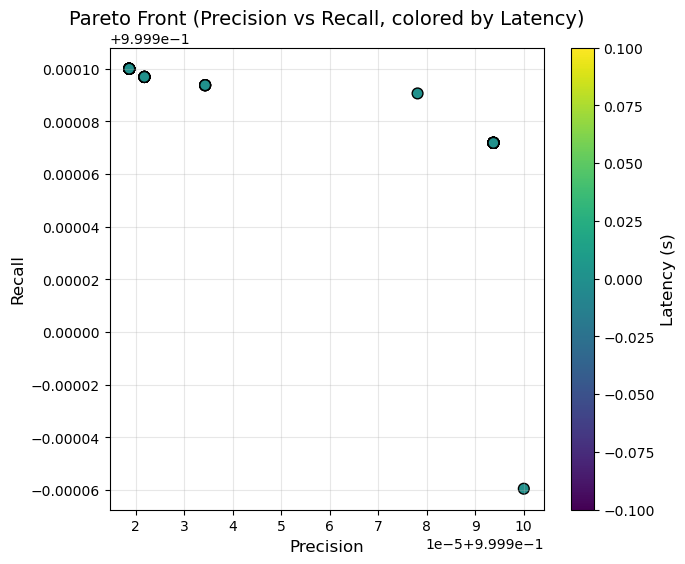

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
sc = plt.scatter(df_front["precision"], df_front["recall"],
                 c=df_front["latency_s"], cmap="viridis", s=60, edgecolor="k")

plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.title("Pareto Front (Precision vs Recall, colored by Latency)", fontsize=14)
cbar = plt.colorbar(sc)
cbar.set_label("Latency (s)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


In [27]:
# ==========================================
# NSGA-II (enforced persistence): maximize Precision & Recall, minimize Latency
# ==========================================
import numpy as np
import pandas as pd
import random

# ---------------------------
# Required inputs from session
# ---------------------------
# Arrays in [0,1] aligned per validation window:
#   ae_val_cdf, pred_val_cdf
# Optional aligned MMSI for per-vessel persistence:
#   VAL_MMSI (1D array-like)
# Config:
#   WIN_STRIDE, DEFAULT_DT_MIN

# ---- Optional MMSI alignment (per-window) ----
try:
    mmsi_val = VAL_MMSI
except NameError:
    mmsi_val = None

# ---------------------------
# Helpers
# ---------------------------
def apply_persistence(flags, mmsi_seq=None, min_run=3):
    f = np.asarray(flags, dtype=int)
    keep = np.zeros_like(f)
    if mmsi_seq is None:
        run = 0
        for i in range(len(f)):
            if f[i] == 1:
                run += 1
            else:
                if run >= min_run:
                    keep[i-run:i] = 1
                run = 0
        if run >= min_run:
            keep[len(f)-run:len(f)] = 1
        return keep
    else:
        m = np.asarray(mmsi_seq)
        start = 0
        for i in range(1, len(f)+1):
            if i == len(f) or m[i] != m[start]:
                seg = f[start:i]
                run = 0
                for j in range(len(seg)):
                    if seg[j] == 1:
                        run += 1
                    else:
                        if run >= min_run:
                            keep[start + j - run : start + j] = 1
                        run = 0
                if run >= min_run:
                    keep[start + len(seg) - run : start + len(seg)] = 1
                start = i
        return keep

def confusion_counts(flags, labels):
    flags  = np.asarray(flags, dtype=int)
    labels = np.asarray(labels, dtype=int)
    tp = int(((flags == 1) & (labels == 1)).sum())
    fp = int(((flags == 1) & (labels == 0)).sum())
    fn = int(((flags == 0) & (labels == 1)).sum())
    tn = int(((flags == 0) & (labels == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec / max(prec + rec, 1e-12)) if (prec + rec) > 0 else 0.0
    fpr  = fp / max(fp + tn, 1)
    acc  = (tp + tn) / max(tp + fp + fn + tn, 1)
    return prec, rec, f1, fpr, acc

# Base inference latency per window in ms (set if profiled; else 0)
BASE_INFER_MS = 0.0
def detection_latency_seconds(min_run, win_stride, dt_min, base_infer_ms=0.0):
    # Confirmation delay from persistence (min_run consecutive windows)
    confirm_delay = max(min_run - 1, 0) * win_stride * dt_min * 60.0
    return confirm_delay + (base_infer_ms / 1000.0)

# ---------------------------
# Proxy labels (choose source, independent of optimizer decisions)
# ---------------------------
LABEL_SOURCE = 'fused'   # 'fused' | 'pred' | 'ae'
LABEL_Q = 0.90

if LABEL_SOURCE == 'fused':
    labels_proxy = ((0.5 * ae_val_cdf + 0.5 * pred_val_cdf) >= LABEL_Q).astype(int)
elif LABEL_SOURCE == 'pred':
    labels_proxy = (pred_val_cdf >= LABEL_Q).astype(int)
elif LABEL_SOURCE == 'ae':
    labels_proxy = (ae_val_cdf >= LABEL_Q).astype(int)
else:
    raise ValueError("LABEL_SOURCE must be 'fused', 'pred', or 'ae'.")

# ---------------------------
# Decision vector & evaluation (ENFORCE PERSISTENCE)
# ---------------------------
# Decision variables:
#   x = [q, alpha, min_run_real]
#   q in [0.70, 0.99], alpha in [0,1], min_run_real in [MIN_RUN_MIN, 6] (rounded later)

MIN_RUN_MIN = 2  # <<< ENFORCED PERSISTENCE (no zero-latency solutions)
LB = np.array([0.70, 0.0, float(MIN_RUN_MIN)], dtype=float)
UB = np.array([0.99, 1.0, 6.0], dtype=float)

def clamp(x):
    return np.minimum(UB, np.maximum(LB, x))

def round_minrun(min_run_real):
    return int(np.clip(int(round(min_run_real)), MIN_RUN_MIN, 6))

def fused_scores(alpha):
    return alpha * ae_val_cdf + (1.0 - alpha) * pred_val_cdf

def evaluate(x):
    # x = [q, alpha, min_run_real]
    q      = float(x[0])
    alpha  = float(x[1])
    mr     = round_minrun(x[2])

    s = fused_scores(alpha)
    flags = (s >= q).astype(int)
    kept  = apply_persistence(flags, mmsi_seq=mmsi_val, min_run=mr)

    tp, fp, fn, tn = confusion_counts(kept, labels_proxy)
    prec, rec, f1, fpr, acc = metrics_from_counts(tp, fp, fn, tn)
    lat_s = detection_latency_seconds(mr, WIN_STRIDE, DEFAULT_DT_MIN, BASE_INFER_MS)

    # Objectives: maximize precision & recall, minimize latency
    # NSGA-II minimizes: use negative for max targets
    f = np.array([-prec, -rec, lat_s], dtype=float)

    info = {
        "q": q, "alpha": alpha, "min_run": mr,
        "precision": prec, "recall": rec, "f1": f1, "fpr": fpr, "acc": acc,
        "latency_s": lat_s, "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "flagged": int(flags.sum()), "kept": int(kept.sum())
    }
    return f, info

# ---------------------------
# NSGA-II components
# ---------------------------
def fast_non_dominated_sort(F):
    N = F.shape[0]
    S = [[] for _ in range(N)]
    n = np.zeros(N, dtype=int)
    ranks = np.zeros(N, dtype=int)
    fronts = [[]]

    def dominates(i, j):
        return np.all(F[i] <= F[j]) and np.any(F[i] < F[j])

    for p in range(N):
        for q in range(N):
            if p == q: continue
            if dominates(p, q):
                S[p].append(q)
            elif dominates(q, p):
                n[p] += 1
        if n[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    ranks[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    fronts.pop()
    return fronts, ranks

def crowding_distance(F, front_idx):
    if len(front_idx) == 0:
        return np.array([])
    M = F.shape[1]
    dist = np.zeros(len(front_idx), dtype=float)
    if len(front_idx) <= 2:
        dist.fill(np.inf)
        return dist
    for m in range(M):
        vals = F[front_idx, m]
        order = np.argsort(vals)
        dist[order[0]]  = np.inf
        dist[order[-1]] = np.inf
        vmin, vmax = vals[order[0]], vals[order[-1]]
        denom = (vmax - vmin) if (vmax - vmin) > 0 else 1.0
        for k in range(1, len(front_idx)-1):
            prev_v = vals[order[k-1]]
            next_v = vals[order[k+1]]
            dist[order[k]] += (next_v - prev_v) / denom
    return dist

def tournament_select(pop, F, ranks):
    i, j = np.random.randint(0, len(pop)), np.random.randint(0, len(pop))
    if ranks[i] < ranks[j]:
        return i
    elif ranks[j] < ranks[i]:
        return j
    else:
        return i if random.random() < 0.5 else j

def sbx_crossover(p1, p2, eta=15.0, prob=0.9):
    if random.random() > prob:
        return p1.copy(), p2.copy()
    c1 = p1.copy(); c2 = p2.copy()
    for d in range(len(p1)):
        if random.random() < 0.5:
            x1, x2 = p1[d], p2[d]
            if abs(x1 - x2) < 1e-12:
                continue
            xl, xu = LB[d], UB[d]
            if x1 > x2:
                x1, x2 = x2, x1
            beta = 1.0 + (2.0*(x1 - xl) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta + 1.0))
            rand = random.random()
            if rand <= 1.0/alpha:
                betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c1d = 0.5 * ((x1 + x2) - betaq * (x2 - x1))
            beta = 1.0 + (2.0*(xu - x2) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta + 1.0))
            if rand <= 1.0/alpha:
                betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
            c2d = 0.5 * ((x1 + x2) + betaq * (x2 - x1))
            c1[d] = np.clip(c1d, LB[d], UB[d])
            c2[d] = np.clip(c2d, LB[d], UB[d])
    return c1, c2

def poly_mutation(x, eta=20.0, prob=0.2):
    y = x.copy()
    for d in range(len(x)):
        if random.random() < prob:
            xl, xu = LB[d], UB[d]
            if abs(xu - xl) < 1e-12:
                continue
            delta1 = (y[d] - xl) / (xu - xl)
            delta2 = (xu - y[d]) / (xu - xl)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.0)
            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0*rand + (1.0 - 2.0*rand)* (xy ** (eta + 1.0))
                deltaq = (val ** mut_pow) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0 - rand) + 2.0*(rand - 0.5)*(xy ** (eta + 1.0))
                deltaq = 1.0 - (val ** mut_pow)
            y[d] = np.clip(y[d] + deltaq * (xu - xl), xl, xu)
    return y

# ---------------------------
# NSGA-II loop
# ---------------------------
def nsga2(pop_size=80, generations=40, cx_prob=0.9, mut_prob=0.2, seed=42):
    random.seed(seed); np.random.seed(seed)
    # Initialize population uniformly within bounds
    pop = []
    for _ in range(pop_size):
        q = np.random.uniform(LB[0], UB[0])
        a = np.random.uniform(LB[1], UB[1])
        r = np.random.uniform(LB[2], UB[2])   # continuous; rounded during eval
        pop.append(np.array([q, a, r], dtype=float))

    def evaluate_pop(pop):
        Fs, infos = [], []
        for x in pop:
            f, info = evaluate(x)
            Fs.append(f); infos.append(info)
        return np.vstack(Fs), infos

    F, infos = evaluate_pop(pop)

    for gen in range(generations):
        fronts, ranks = fast_non_dominated_sort(F)

        # Crowding distances per front
        crowd = np.zeros(len(pop), dtype=float)
        for fr in fronts:
            d = crowding_distance(F, fr)
            for k, idx in enumerate(fr):
                crowd[idx] = d[k]

        # Selection (binary tournament)
        parents = []
        while len(parents) < pop_size:
            i = tournament_select(pop, F, ranks)
            j = tournament_select(pop, F, ranks)
            parents.append(pop[i].copy()); parents.append(pop[j].copy())
        parents = parents[:pop_size]

        # Variation
        offspring = []
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[(i+1) % pop_size]
            c1, c2 = sbx_crossover(p1, p2, prob=cx_prob)
            c1 = poly_mutation(c1, prob=mut_prob)
            c2 = poly_mutation(c2, prob=mut_prob)
            offspring.append(clamp(c1)); offspring.append(clamp(c2))
        offspring = offspring[:pop_size]

        # Evaluate offspring
        F_off, infos_off = evaluate_pop(offspring)

        # Environmental selection: combine, sort by rank then crowding, keep pop_size
        pop2 = pop + offspring
        F2   = np.vstack([F, F_off])
        fronts2, _ = fast_non_dominated_sort(F2)

        new_pop, new_F, new_infos = [], [], []
        for fr in fronts2:
            if len(new_pop) + len(fr) <= pop_size:
                for idx in fr:
                    new_pop.append(pop2[idx])
                    new_F.append(F2[idx])
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
            else:
                d = crowding_distance(F2, fr)
                order = np.argsort(-d)  # descending
                need = pop_size - len(new_pop)
                for t in order[:need]:
                    idx = fr[t]
                    new_pop.append(pop2[idx])
                    new_F.append(F2[idx])
                    info = infos[idx] if idx < len(pop) else infos_off[idx - len(pop)]
                    new_infos.append(info)
                break

        pop, F, infos = new_pop, np.vstack(new_F), new_infos

        if (gen+1) % 5 == 0 or gen == generations-1:
            best_prec = max(inf["precision"] for inf in infos)
            best_rec  = max(inf["recall"]   for inf in infos)
            min_lat   = min(inf["latency_s"] for inf in infos)
            print(f"[NSGA-II] Gen {gen+1}/{generations} | max P={best_prec:.3f}, max R={best_rec:.3f}, min Lat={min_lat:.1f}s")

    # Final non-dominated front (rank 0)
    fronts, ranks = fast_non_dominated_sort(F)
    pareto_idx = fronts[0]
    pareto_pop  = [pop[i] for i in pareto_idx]
    pareto_info = [infos[i] for i in pareto_idx]

    # Pack results
    df_all = pd.DataFrame(infos)
    df_all["q_raw"] = [p[0] for p in pop]
    df_all["alpha_raw"] = [p[1] for p in pop]
    df_all["min_run_raw"] = [p[2] for p in pop]

    df_front = pd.DataFrame(pareto_info)
    df_front["q_raw"] = [p[0] for p in pareto_pop]
    df_front["alpha_raw"] = [p[1] for p in pareto_pop]
    df_front["min_run_raw"] = [p[2] for p in pareto_pop]

    # Representative picks
    balanced  = df_front.sort_values(["f1","precision","recall"], ascending=[False,False,False]).head(1)
    hi_recall = df_front.sort_values(["recall","precision","latency_s"], ascending=[False,False,True]).head(1)
    low_lat   = df_front.sort_values(["latency_s","f1","precision"], ascending=[True,False,False]).head(1)

    print("\n=== NSGA-II complete ===")
    print(f"Population: {len(pop)}  |  Pareto front size: {len(df_front)}")
    print("\nBalanced pick (highest F1 on Pareto front):")
    print(balanced[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])
    print("\nHigh-recall pick:")
    print(hi_recall[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])
    print("\nLow-latency pick:")
    print(low_lat[["q","alpha","min_run","precision","recall","f1","latency_s","fpr","kept"]])

    # (Optional) save
    try:
        df_all.to_csv("./cache_streaming/nsga2_population.csv", index=False)
        df_front.to_csv("./cache_streaming/nsga2_pareto_front.csv", index=False)
        print("\nSaved: ./cache_streaming/nsga2_population.csv and ./cache_streaming/nsga2_pareto_front.csv")
    except Exception as e:
        print("\n[warn] Could not save CSVs:", e)

    return df_all, df_front

# ---------------------------
# Run NSGA-II
# ---------------------------
# Tweak pop_size / generations as needed (e.g., 120 / 60 for a deeper search)
df_all, df_front = nsga2(pop_size=100, generations=50, cx_prob=0.9, mut_prob=0.2, seed=42)


[NSGA-II] Gen 5/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 10/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 15/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 20/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 25/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 30/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 35/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 40/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 45/50 | max P=1.000, max R=0.994, min Lat=1200.0s
[NSGA-II] Gen 50/50 | max P=1.000, max R=0.994, min Lat=1200.0s

=== NSGA-II complete ===
Population: 100  |  Pareto front size: 100

Balanced pick (highest F1 on Pareto front):
           q  alpha  min_run  precision    recall        f1  latency_s  \
61  0.899509    0.5        2   0.994624  0.890535  0.939706     1200.0   

         fpr    kept  
61  0.000421  286285  

High-recall pick:
          q     alpha  min_run  p